# Link between GitHub repository and ExTRI2 paper
A notebook containing links to, or code for, generating the figures, tables, and results for the ExTRI2 paper, divided by the different sections in the paper.

Go to each section to see the analysis done, or a link to the script/notebook that contains the information.

In [1]:
__import__('sys').path.append('../scripts/common/'); __import__('notebook_utils').table_of_contents('repo_to_paper.ipynb')

<h3>Table of contents</h3>


[Link between GitHub repository and ExTRI2 paper](#Link-between-GitHub-repository-and-ExTRI2-paper)
- [Setup & configuration](#Setup-&-configuration)
- [2.1. Overview of the ExTRI2 pipeline](#2.1.-Overview-of-the-ExTRI2-pipeline)
- [2.2. Data sources and preparation](#2.2.-Data-sources-and-preparation)
  - [2.2.1 Retrieving annotated abstracts from PubTator3](#2.2.1-Retrieving-annotated-abstracts-from-PubTator3)
  - [2.2.2 Retrieving TF Gene IDs from TFCheckpoint and GO annotations](#2.2.2-Retrieving-TF-Gene-IDs-from-TFCheckpoint-and-GO-annotations)
- [2.3 Curated dataset for training – The NTNU collection & 3.1 The NTNU collection](#2.3-Curated-dataset-for-training-–-The-NTNU-collection-&-3.1-The-NTNU-collection)
- [2.4. Classifier configuration and training & 3.4.1. Classifiers performance](#2.4.-Classifier-configuration-and-training-&-3.4.1.-Classifiers-performance)
- [2.5 Improvement of the training dataset & 3.1.1. Dataset refinement outcomes](#2.5-Improvement-of-the-training-dataset-&-3.1.1.-Dataset-refinement-outcomes)
  - [2.5.1 Sentence splitter](#2.5.1-Sentence-splitter)
  - [2.5.2 Iterative classifier training and dataset revision](#2.5.2-Iterative-classifier-training-and-dataset-revision)
- [2.6. Validation criteria and process & 3.4.2. Manual validation outcomes](#2.6.-Validation-criteria-and-process-&-3.4.2.-Manual-validation-outcomes)
- [3.2. The ExTRI2 resource](#3.2.-The-ExTRI2-resource)
- [Supp. File. Post-processing](#Supp.-File.-Post-processing)
- [2.7, 2.8, 3.3. CollecTRI](#2.7,-2.8,-3.3.-CollecTRI)

## Setup & configuration

In [2]:
# IMPORTS
import pandas as pd
import numpy as np
import os
import json
from IPython.display import display, HTML
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
from matplotlib_venn import venn3
import matplotlib.colors as mcolors

import upsetplot
import warnings
import re
from analysis import *

from Bio import Entrez
# *Always* tell NCBI who you are
Entrez.email = "example24@gmail.com"

## Custom functions
import sys

sys.path.append('../scripts/common/')
from notebook_utils import h3, h4, h5, md
from analysis import load_config, modify_TF_type, save_paper_validated_df, combine_discarded_sents, create_paper_TF_tables
pd.set_option('display.max_colwidth', 20)

In [25]:
# LOAD DATA
config = load_config()

# Load ExTRI dataset
results_ExTRI2_df = pd.read_csv(config['final_ExTRI2_p'], sep="\t", dtype=str, keep_default_na=False)

# Load the validation dataset
validated_df = pd.read_csv(config['final_validated_p'], sep='\t', header=0, dtype=str)

# Load the supp. file with all TF IDs, and modify TF type
all_TFs_df = pd.read_csv("tables/all_TFs.tsv", sep="\t", dtype=str)

In [26]:
# PREPARE DATA IN THE PAPER FORMAT

# --- Modify ExTRI2 dataset ---
md("ExTRI2 df:")
# Modify TF type to the new categorisation
ExTRI2_df = modify_TF_type(results_ExTRI2_df, all_TFs_df)
# Save dataset for the paper
ExTRI2_df.to_csv(config['paper_ExTRI2_p'], compression='gzip', sep="\t", index=False)
# Add extra columns to ExTRI
ExTRI2_df['TRI Id'] = ExTRI2_df['TF Id'] + '|' + ExTRI2_df['TG Id']

# --- Modify validated_df dataset ---
md("Validated df:")
# Save dataset for the paper
validated_df = save_paper_validated_df(validated_df, all_TFs_df, config['paper_validated_p'])
# Make the 3 categories ordinal
tf_types = ['dbTF', 'coTF', 'coTF candidate']
validated_df['TF_type'] = pd.Categorical(validated_df['TF_type'], categories=tf_types, ordered=True)

# --- Combine the 2 tables regarding discarded sentences ---
combine_discarded_sents(config)

# --- Create TF tables from all_TFs table --- 
# Add "In ExTRI2" in the all_TFs_df dataframe for analysis
all_TFs_df = create_paper_TF_tables(ExTRI2_df, all_TFs_df, config)

ExTRI2 df:

Difference between old and new TF types:


TF_type          new_TF_type                  
dbTF             dbTF                             436506
ll_coTF          coTF candidate                   210105
coTF             coTF candidate                   112946
                 coTF                              85744
ll_coTF;ll_coTF  coTF candidate;coTF candidate      9872
Name: count, dtype: int64

Removed 3613 (0.41%) rows with no TF type (877268 -> 873655)


Validated df:

Difference between old and new TF types:


TF_type  new_TF_type   
dbTF     dbTF              3678
ll_coTF  coTF candidate    1392
coTF     coTF candidate    1306
         coTF               652
ll_coTF  coTF                78
Name: count, dtype: int64

Removed 104 (1.43%) rows with no TF type (7290 -> 7186)
Saved all discarded sentences in ../data/paper_tables/discarded_sents.tsv
We will discard 528 TFs that are not classified into any TF type


In [5]:
# SHOW THE DATASETS
pd.set_option("max_colwidth", 50)
pd.set_option('display.max_columns', None)
md("ExTRI2 resource:")
display(ExTRI2_df.head(1))
md("Validated dataset:")
display(validated_df.head(1))
pd.set_option("max_colwidth", 20)
pd.set_option('display.max_columns', 20)

ExTRI2 resource:

,#SentenceID,Sentence,TF,TG,TF Id,TG Id,TF offset,Gene offset,TRI score,Valid,MoR scores,MoR,PMID,PMID+Sent+TRI_Id,TF Symbol,TF TaxID,TG Symbol,TG TaxID,renormalisation,TF_human_Id,TF_human_symbol,TF_HGNC_Id,TG_human_Id,TG_human_symbol,TG_HGNC_Id,TF_type,TRI Id
0,PMID:35388756:pubtator_title_and_abstract:cb42...,Chip-IP results showed that [TF] might regulat...,CHCHD2,GNPTG,51142,84572,1366,1458,0.992724397527042,Valid,0.9978505824903713;0.0012786891397542478;0.000...,UNDEFINED,35388756,35388756|9|51142|84572,CHCHD2,9606,GNPTG,9606,,51142,CHCHD2,HGNC:21645,84572,GNPTG,HGNC:23026,coTF candidate,51142|84572


Validated dataset:

,#SentenceID,Sentence,TRI,MoR,Valid?,true_TRI,true_MoR,TRI score,MoR scores,TF,TF Id,TF Symbol,TF TaxID,TF_is_incorrect,TF_correct_mention,TF offset,TG,TG Id,TG Symbol,TG TaxID,TG_is_incorrect,TG_correct_mention,Gene offset,method,renormalisation,pre-post,TF_type,Other issues,Explanation
0,10490613:2:NF-kappaB.:IL-8,A hallmark of inflammation is the burst-like f...,TRI,ACTIVATION,F,Not TRI,NaN,NaN,0.008336135226008932;0.9909433236649396;0.0007...,NF-kappaB.,Complex:NFKB,NFKB,9606,NaN,NaN,464,IL-8,3576,CXCL8,9606,NaN,NaN,538,random,NFKB,pre,dbTF,Splitter,NaN


## 2.1. Overview of the ExTRI2 pipeline

Scripts used for the different parts of the pipeline:
1. **Abstracts and Entity Extraction:** See [scripts/preprocessing/README.md](../scripts/preprocessing/README.md) for a description of the different scripts used
2. **Abstract Segmentation and Candidate Sentences Creation:** [workflow.rb](../workflow.rb)
3. **Identification of TRIs and their MoR:** [workflow.rb](../workflow.rb), using classifiers trained with [classifiers_training/run_classifiers.sh](../classifiers_training/run_classifiers.sh)
4. **Post-processing and normalization:** [postprocessing.py](../scripts/postprocessing/postprocessing.py) and [postprocessing_checkings.ipynb](../scripts/postprocessing/postprocessing_checkings.ipynb)

## 2.2. Data sources and preparation

### 2.2.1 Retrieving annotated abstracts from PubTator3
See [get_all_pubtators.sh](../scripts/preprocessing/get_all_pubtators.sh)

### 2.2.2 Retrieving TF Gene IDs from TFCheckpoint and GO annotations
See [get_NCBI_TF_IDs.ipynb](../scripts/preprocessing/get_NCBI_TF_IDs.ipynb)

## 2.3 Curated dataset for training – The NTNU collection & 3.1 The NTNU collection

See [update_tri_sentences.ipynb](../scripts/classifiers_training/update_tri_sentences.ipynb) for details on how the final_NTNU_df was created.

In [6]:
# Original annotated sentences
original_NTNU_df = pd.read_csv('../data/external/original_tri_sentences.tsv', sep='\t', skiprows=1)

# Sentences used for training the models (where suboptimal sentences are "Not TRI")
training_df = pd.read_csv('../classifiers_training/data/tri_sentences.tsv', sep='\t')

# Final NTNU dataset - It will be integrated inside CollecTRI, thus not used
# final_NTNU_df = pd.read_csv('../results/NTNU_dataset.tsv', sep='\t')

def display_NTNU_analysis(original_NTNU_df, final_NTNU_df):
    md("Comparison of original and final NTNU datasets")
    NTNU_analysis = {'Original': {}, 'Final': {}}

    for name, df in [('Original', original_NTNU_df), ('Final', final_NTNU_df)]: 
        NTNU_analysis[name]['Total'] = len(df)
        NTNU_analysis[name]['Unique'] = len(df[['Sentence', 'TF', 'TG']].drop_duplicates())
        NTNU_analysis[name]['Duplicated'] = (df[['Sentence', 'TF', 'TG']].duplicated().sum())


        for TRI in [False, True]:
            NTNU_analysis[name][TRI] = len(df[df['Label'] == TRI])
        for MoR in ['UNDEFINED', 'ACTIVATION', 'REPRESSION']:
            NTNU_analysis[name][MoR] = len(df[df['Type'] == MoR])
            
    NTNU_analysis = pd.DataFrame.from_dict(NTNU_analysis)
    NTNU_analysis['difference'] = NTNU_analysis['Final'] - NTNU_analysis['Original']

    display(NTNU_analysis.map(lambda x: f"{x:,}" if isinstance(x, int) else x))

def save_NTNU_dataset(training_df, path):
    "Change NTNU dataset so it has the expected format of the paper"
    paper_NTNU = training_df.copy()

    # Rename columns to match the paper format
    paper_NTNU.rename(columns={'Label': 'TRI', 'Type': 'MoR'}, inplace=True)
    paper_NTNU['TRI'] = paper_NTNU['TRI'].replace({False: 'Not TRI', True: 'TRI'})

    # Drop unneeded columns
    paper_NTNU.drop(columns=['validated?', 'Unnamed: 0'], inplace=True)

    # Save into tables
    pd.DataFrame.to_csv(paper_NTNU, path, index=False, header=True, sep='\t')

    display(paper_NTNU.head())

# Show content of the NTNU training set
display_NTNU_analysis(original_NTNU_df, training_df)

# Save into "paper_tables/" in the correct format
save_NTNU_dataset(training_df, config['NTNU_dataset_p'])

Comparison of original and final NTNU datasets

,Original,Final,difference
Total,"22,135","21,572",-563
Unique,"21,766","21,572",-194
Duplicated,369,0,-369
False,"10,986","10,169",-817
True,"11,149","11,403",254
UNDEFINED,"3,884","4,044",160
ACTIVATION,"5,339","5,344",5
REPRESSION,"1,926","2,015",89


,#TRI ID,Sentence,TF,TG,TRI,MoR
0,16373364:0:Ets1:...,"A role for [TF],...",Ets1,GATA-3,Not TRI,NaN
1,16373364:0:Ets1:...,"A role for [TF],...",Ets1,IL-5,TRI,UNDEFINED
2,16373364:0:Ets1:...,"A role for [TF],...",Ets1,AP-1,Not TRI,NaN
3,16373364:0:GATA-...,"A role for [TG],...",GATA-3,Ets1,Not TRI,NaN
4,16373364:0:GATA-...,"A role for Ets1,...",GATA-3,IL-5,TRI,UNDEFINED


## 2.4. Classifier configuration and training & 3.4.1. Classifiers performance

**2.4**<br>
Facts stated in the text
* Train-test split is 85:15 - [src/dataset.py](../classifiers_training/src/dataset.py)
* **Table S3:** Values obtained from [classifiers_comparison.ipynb/Final iteration](classifiers_comparison.ipynb)
* **Table S4 and Table S5:** Values obtained from [classifiers_comparison.ipynb/Previous iterations](classifiers_comparison.ipynb)

**3.4.1.**<br>
Final models F1 score on test dataset: 0.94 for TRI and 0.95 for MoR. Obtained from [classifiers_comparison.ipynb/Final models](classifiers_comparison.ipynb). There is also a confusion matrix there.

## 2.5 Improvement of the training dataset & 3.1.1. Dataset refinement outcomes

### 2.5.1 Sentence splitter
From [update_tri_sentences.ipynb#Modify_joined_sentences](../scripts/classifiers_training/update_tri_sentences.ipynb) we extract the claim that "sciSpacy detected 54 sentences (0.25% of the dataset) that required further splitting. They were discarded"

### 2.5.2 Iterative classifier training and dataset revision
**Facts stated in the text:**
* We revised **3111 sentences** (14.4% of the dataset) ([prepare_reannotation_Excels.ipynb#Compare original and revised datasets](../scripts/classifiers_training/prepare_reannotation_Excels.ipynb)):
  *  3086 from the original NTNU dataset plus 25 extra negative sentences. We modified the label in **1991** of those sentences [update_tri_sentences.ipynb#Reannotations](../scripts/classifiers_training/update_tri_sentences.ipynb)

Figures and tables:
* **Figure 5** made in [prepare_reannotation_Excels.ipynb#Compare original and revised datasets](../scripts/classifiers_training/prepare_reannotation_Excels.ipynb)
* **Table 6** can partly be found in [prepare_reannotation_Excels.ipynb#Compare original and revised datasets](../scripts/classifiers_training/prepare_reannotation_Excels.ipynb) but standard deviation and MoR classifiers data is obtained from [classifiers_comparison.ipynb](classifiers_comparison.ipynb)
* **Table S11** in [prepare_reannotation_Excels.ipynb#Comparison of the worst predicted sentences (threshold=0.2) between the different iterations](../scripts/classifiers_training/prepare_reannotation_Excels.ipynb)

## 2.6. Validation criteria and process & 3.4.2. Manual validation outcomes

TF distribution for the three TF types for the random and balanced datasets (pre post-processing rules)

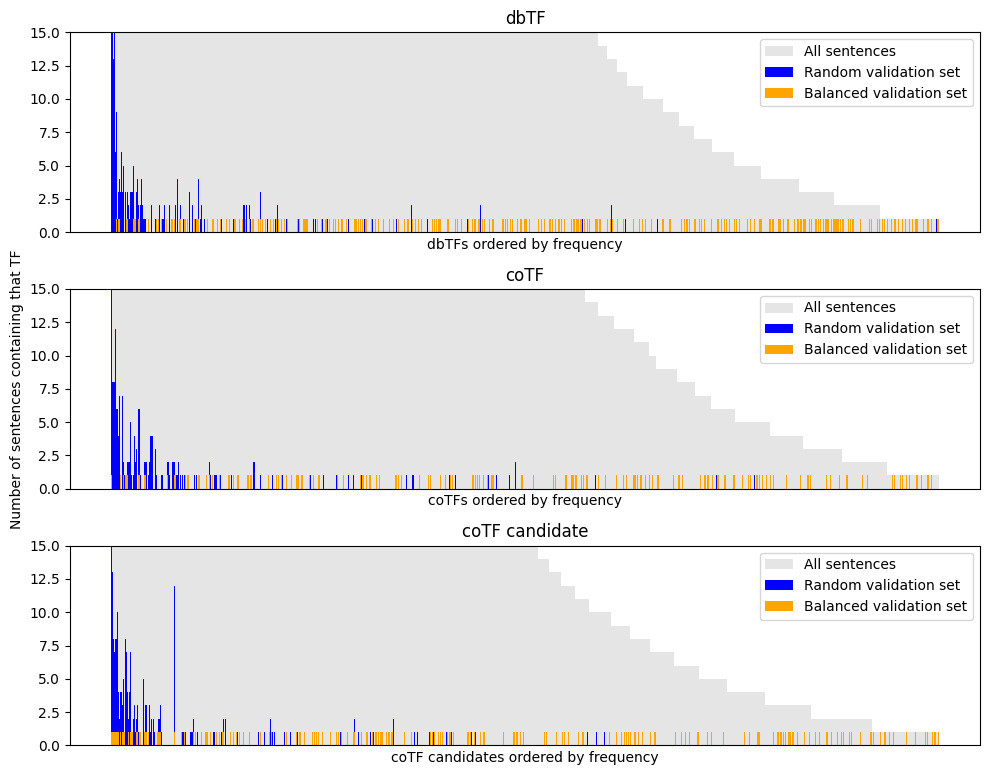

TF distribution for the three TF types for the random and balanced datasets (post post-processing rules)

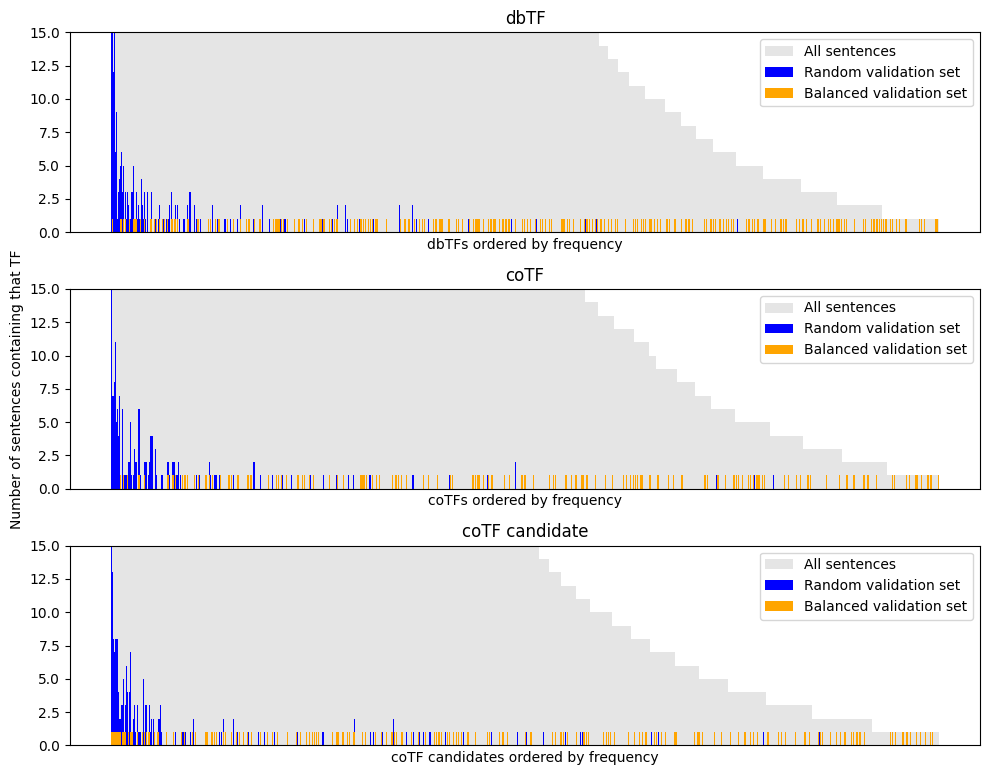

In [7]:
# PLOT - Ensure correctly balanced validation dataset
def plot_tf_validation_distribution(ax, tf_type: str, all_sents: pd.DataFrame, val_random: pd.DataFrame, val_balanced: pd.DataFrame, ylim=30):
    for df, label, color, alpha in [
        (all_sents, "All sentences", "grey", 0.2),
        (val_random, "Random validation set", "blue", 1),
        (val_balanced, 'Balanced validation set', "orange", 1)
    ]:
        counts = df['TF Id'].value_counts()
        ax.bar(counts.index, counts, label=label, color=color, alpha=alpha, width=1)
    ax.set_title(tf_type)
    ax.set_xticks([])
    #plt.xticks(rotation='vertical')
    ax.set_xlabel(f"{tf_type}s ordered by frequency")
    ax.set_ylim((0,ylim))
    ax.legend()

def plot_all_tf_validation_distributions(title, ExTRI2_df, validated_1mapping, figsize=(15, 10), ylim=30):

    fig, axes = plt.subplots(3, 1, figsize=figsize)
    for i, TF_type in enumerate(validated_1mapping['TF_type'].cat.categories):
        TRI_subset = ExTRI2_df[ExTRI2_df['TF_type'] == TF_type]
        validated_subset = validated_1mapping[(validated_1mapping['TF_type'] == TF_type)]

        validated_subset_b = validated_subset[validated_subset['method'] == 'balanced']
        validated_subset_r = validated_subset[validated_subset['method'] == 'random']

        plot_tf_validation_distribution(axes[i], TF_type, TRI_subset, val_balanced = validated_subset_b, val_random = validated_subset_r, ylim=ylim)
    axes[1].set_ylabel(f"Number of sentences containing that TF")

    plt.suptitle(title)
    plt.tight_layout()
    plt.show()

for pre_post in ["pre", "post"]:
    md(f"TF distribution for the three TF types for the random and balanced datasets ({pre_post} post-processing rules)")
    plot_all_tf_validation_distributions("", ExTRI2_df, validated_df[(validated_df['pre-post'] == pre_post) & (validated_df['TRI'] == 'TRI')], figsize=(10, 8), ylim = 15)

In [8]:
def evaluate_other_issues(validated_df):
    h3("Other issues")

    # Get sentences where there are other issues
    o_i = validated_df.drop_duplicates(subset=['#SentenceID'], keep='first').dropna(subset=['Other issues'])

    # Display common issues
    display(o_i['Other issues'].apply(lambda x: x.split(';')).explode().value_counts())

    # Get uniquely validated sentences
    validated_unique = validated_df.drop_duplicates(subset=['#SentenceID'], keep='first')

    # Splitter / suboptimal / dir-gene issues
    m = validated_unique['Other issues'].fillna('').str.contains('Splitter')
    print(f"{m.sum()}/{len(m)} ({m.sum()/len(m):.1%}) sentences are incorrecty splitted")
    m = validated_unique['Other issues'].fillna('').str.contains('suboptimal')
    print(f"{m.sum()}/{len(m)} ({m.sum()/len(m):.1%}) sentences are suboptimal")
    # m = validated_unique['dir-*'].fillna('') == 'dir-gene'
    # print(f"{m.sum()}/{len(m)} ({m.sum()/len(m):.1%}) sentences classified as 'dir-gene")

    # Check for more common issues, what proportion of the dataset do they appear in
    results = []
    for tf_type in validated_df['TF_type'].cat.categories:
        for method in ['random', 'balanced']:
            for p in ['pre', 'post']:
                for validity in ['T', 'F']:

                    df = validated_df[(validated_df['TF_type'] == tf_type) & (validated_df['method'] == method) & (validated_df['pre-post'] == p) & (validated_df['TRI'] == 'TRI') & (validated_df['Valid?'] == validity)]
                    
                    r = {
                        'tf_type': tf_type,
                        'Valid?': validity,
                        'method': method,
                        'pre-post': p,
                        'num_sents': str(len(df))
                    }

                    for issue in ['mutation', 'PPI', 'negation']:
                        m = df['Other issues'].fillna('').str.contains(issue)
                        r[issue] = len(df[m]) / len(df) if m.sum() > 0 else 0
            
                    results.append(r)
    
    index_cols = ['tf_type', 'Valid?', 'method', 'pre-post']
    return pd.DataFrame(results).sort_values(by=index_cols).set_index(index_cols)
  
def display_o_i_joined_pre_post(o_i_results, tf_types):

    index = ['tf_type', 'Valid?', 'method']
    # Pivot pre-post from row index to column index
    o_i_pivot = o_i_results.reset_index().pivot_table(
        index=index,
        columns='pre-post',
        values=['num_sents', 'mutation', 'PPI', 'negation'],
        aggfunc= lambda x: x#f"{x:.2%}" if isinstance(x, float) else str(x)
    )

    # Convert all values to strings for easier handling
    for col in ['mutation', 'PPI', 'negation']:
        o_i_pivot[col] = o_i_pivot[col].map(lambda x: f"{x:.1%}" if isinstance(x, (float)) else str(x))

    # Combine pre and post columns for each metric
    for col in ['mutation', 'PPI', 'negation', 'num_sents']:
        o_i_pivot[(col, 'pre-post')] = (
            o_i_pivot[(col, 'pre')].astype(str) + ' - ' + o_i_pivot[(col, 'post')].astype(str)
        )

    # Filter unnecessary columns
    o_i_pivot = o_i_pivot.filter(like='pre-post')

    # Drop pre-post level
    o_i_pivot.columns = o_i_pivot.columns.droplevel(level=1)

    # Sort tf_type in their categorical order
    o_i_pivot = o_i_pivot.reset_index()
    o_i_pivot['tf_type'] = pd.Categorical(
        o_i_pivot['tf_type'], categories=tf_types, ordered=True
    )
    o_i_pivot = o_i_pivot.sort_values(by=index).set_index(index)


    h3('Other issues, pre-post')
    display(o_i_pivot)

o_i_results = evaluate_other_issues(validated_df)
display_o_i_joined_pre_post(o_i_results, tf_types)

<h3>Other issues</h3>

Other issues
mutation      779
PPI           362
Splitter       52
negation       36
suboptimal      5
Name: count, dtype: int64

52/3905 (1.3%) sentences are incorrecty splitted
5/3905 (0.1%) sentences are suboptimal


<h3>Other issues, pre-post</h3>

mutation            PPI     negation  \
tf_type        Valid? method                                                
dbTF           F      balanced    6.8% - 8.3%  18.6% - 24.2%  0.6% - 1.7%   
                      random    18.7% - 19.2%    5.8% - 4.8%  2.2% - 2.4%   
               T      balanced  24.0% - 21.4%    0.0% - 0.0%  1.4% - 0.9%   
                      random    30.8% - 30.7%    0.0% - 0.0%  1.6% - 1.6%   
coTF           F      balanced    0.0% - 0.0%  51.9% - 58.9%  0.0% - 0.0%   
                      random      6.9% - 8.3%  43.1% - 52.1%  0.0% - 0.0%   
               T      balanced  38.9% - 33.7%    0.0% - 0.0%  1.1% - 0.0%   
                      random    39.2% - 39.0%    0.0% - 0.0%  0.0% - 0.0%   
coTF candidate F      balanced    1.7% - 1.9%  43.8% - 50.5%  0.0% - 0.9%   
                      random      2.7% - 3.3%  45.5% - 53.5%  0.3% - 0.4%   
               T      balanced  40.3% - 36.8%    0.0% - 0.0%  1.2% - 1.4%   
                      random    40.7% - 40.4%    0.0% - 0.0%  1.7% - 1.8%   

                                num_sents  
tf_type        Valid? method               
dbTF           F      balanced  161 - 120  
                      random    139 - 125  
               T      balanced  658 - 682  
                      random    760 - 755  
coTF           F      balanced    54 - 56  
                      random      58 - 48  
               T      balanced    90 - 98  
                      random    143 - 141  
coTF candidate F      balanced  240 - 214  
                      random    332 - 273  
               T      balanced  330 - 348  
                      random    408 - 396

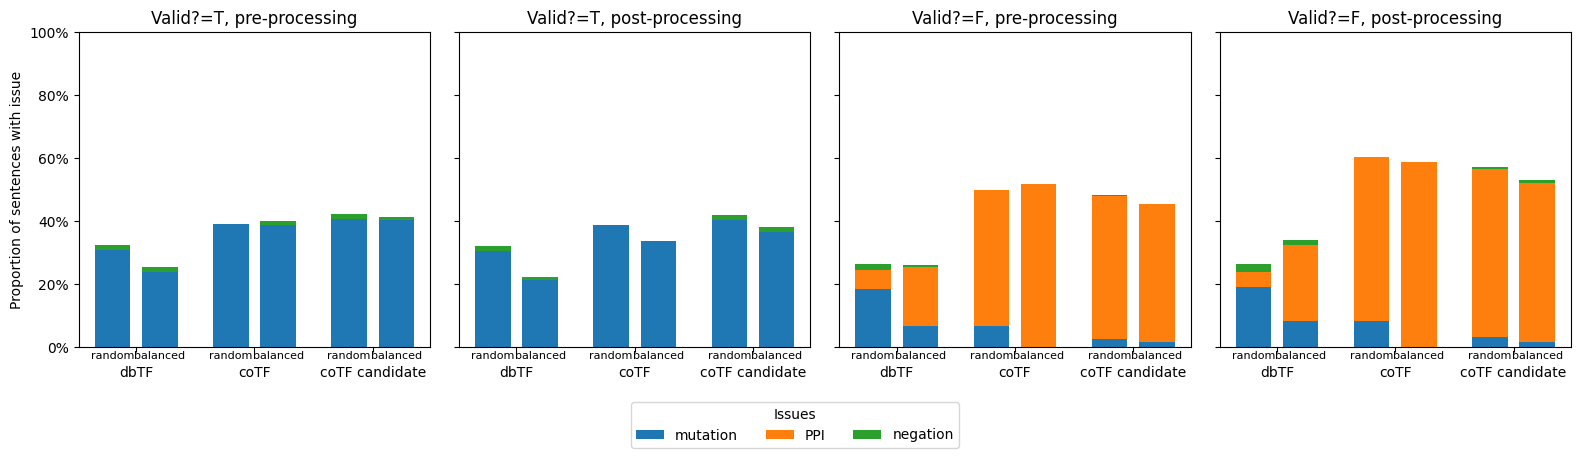

In [9]:
def plot_other_issues_by_combination(o_i_results, tf_types, figsize=(14, 4)):
    # Reset the index to use the index columns as regular columns
    o_i_results_reset = o_i_results.reset_index()

    # Define issues and tf_types
    issues = ['mutation', 'PPI', 'negation']
    hue = 'method'  # Random/Balanced will be the hue
    hue_levels = ['random', 'balanced']  # Ensure this order
    bar_width = 0.2
    group_width = bar_width * len(hue_levels) + 0.1
    withingroup_space = 0.05

    # Define combinations of Valid? and pre-post
    combinations = [
        {'Valid?': 'T', 'pre-post': 'pre'},
        {'Valid?': 'T', 'pre-post': 'post'},
        {'Valid?': 'F', 'pre-post': 'pre'},
        {'Valid?': 'F', 'pre-post': 'post'},
    ]

    # Create a plot for each combination
    fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(16, 4), sharey=True)
    # axes = axes.flatten()

    for i, (ax, combination) in enumerate(zip(axes, combinations)):
        # Filter data for the current combination
        filtered = o_i_results_reset[
            (o_i_results_reset['Valid?'] == combination['Valid?']) &
            (o_i_results_reset['pre-post'] == combination['pre-post'])
        ]

        # Group data by tf_type and method
        grouped = filtered.groupby(['tf_type', hue])[issues].mean().reset_index()

        # Ensure tf_types and hue levels are consistent
        grouped['tf_type'] = pd.Categorical(grouped['tf_type'], categories=tf_types, ordered=True)
        grouped[hue] = pd.Categorical(grouped[hue], categories=hue_levels, ordered=True)
        grouped = grouped.sort_values(['tf_type', hue])

        # Set bar positions
        x = np.arange(len(tf_types)) * group_width

        # Plot stacked bars for each hue level
        for j, level in enumerate(hue_levels):
            level_data = grouped[grouped[hue] == level]

            # Initialize bottom values
            bottom = np.zeros(len(tf_types))

            # Plot each issue as a stacked segment
            for k, issue in enumerate(issues):
                ax.bar(
                    x + j * bar_width,  # Offset bars within the group
                    level_data[issue],
                    width=bar_width - withingroup_space,
                    bottom=bottom,
                    label=issue if j == 0 else "",
                    color=f'C{k}'
                )
                bottom += level_data[issue]

        # Add TF type labels below the bars
        ax.set_xticks(x + (bar_width * len(hue_levels) / 2) - bar_width / 2)
        ax.set_xticklabels(['' for _ in tf_types])  # Temporarily blank x-ticks

        # ax.set_xticklabels(tf_types)
        ax.set_title(f"Valid?={combination['Valid?']}, {combination['pre-post']}-processing")

        # # Add individual hue labels below each bar and move TF type labels further down
        ax.set_xticks(x + (bar_width * len(hue_levels) / 2) - bar_width / 2)  # Center the group


        # Add individual bar labels for the method
        for j, level in enumerate(hue_levels):
            for idx, tf_type in enumerate(tf_types):
                ax.text(
                    x[idx] + j * bar_width,  # Position based on the bar
                    -0.01,  # Move further down
                    f"{level}", ha="center", va="top", fontsize=8, rotation=0
                )

        # Add TF type labels below the hue labels
        for idx, tf_type in enumerate(tf_types):
            ax.text(
                x[idx] + (bar_width * (len(hue_levels) - 1) / 2),  # Center the label below the group
                -0.06,  # Move further down
                f"{tf_type}", ha="center", va="top", fontsize=10,
            )

        # Format the axes
        ax.set_ylim(0, 1)
        ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: f'{y:.0%}'))

        if i == 0:
            ax.set_ylabel('Proportion of sentences with issue')

    # Add a single legend
    fig.legend(
        labels=issues, loc='lower center', ncol=len(issues), title="Issues",
        bbox_to_anchor=(0.5, -0.15), fontsize=10
    )

    # Adjust layout
    plt.tight_layout()
    plt.show()

plot_other_issues_by_combination(o_i_results, tf_types)

In [10]:
# RESULTS
def TRI_validation_results_table(validated_df):
    '''Make table with validation results. Only include TRUE labels'''

    # Only consider TRUE labels
    validated_df_true = validated_df[validated_df['TRI'] == 'TRI']

    results = []
    for tf_type in validated_df['TF_type'].cat.categories:
        for method in ['random', 'balanced']:
            for p in ['pre', 'post']:
                df = validated_df_true[(validated_df_true['TF_type'] == tf_type) & (validated_df_true['method'] == method) & (validated_df_true['pre-post'] == p)]
                
                r = {
                    'tf_type': tf_type,
                    'method': method,
                    'validation stage': p,
                    'num_sents': len(df)
                }

                # Get number of sentences with correct TRIs
                m_T_TRI_df = df['true_TRI'] == 'TRI'
                r['Num correct TRIs'] = m_T_TRI_df.sum()

                # Get NER & norm stats
                r['NER'] = 1 - sum(((df[f'{T}_is_incorrect'].str.contains('NER')).sum() for T in ['TF', 'TG'])) / r['num_sents']
                r['NER-TF'] = 1 - (df[f'TF_is_incorrect'].str.contains('NER')).sum() / r['num_sents']
                r['NER-TG'] = 1 - (df[f'TG_is_incorrect'].str.contains('NER')).sum() / r['num_sents']

                r['norm'] = 1 - sum(((df[f'{T}_is_incorrect'].str.contains('norm')).sum() for T in ['TF', 'TG'])) / r['num_sents']
                r['norm-TF'] = 1 - (df[f'TF_is_incorrect'].str.contains('norm')).sum() / r['num_sents']
                r['norm-TG'] = 1 - (df[f'TG_is_incorrect'].str.contains('norm')).sum() / r['num_sents']

                # Get TRI stats
                r['TRI'] = 1 - (df['TRI'] != df['true_TRI']).sum() / r['num_sents']

                # Get MoR stats - over those whose true_TRI is TRI
                # (1) Correctly labelled / all sentences
                MoR_df = df[m_T_TRI_df]
                r['MoR'] = len(MoR_df[(MoR_df['MoR'] == MoR_df['true_MoR'])]) / len(MoR_df)

                # Get final probability                
                r['Overall']  = ((df['Valid?'] == 'T') & df[f'TF_is_incorrect'].isna() & df[f'TG_is_incorrect'].isna() ).sum() / r['num_sents']

                # Get the breakdown of MoR labels
                # Precision: Correctly labelled / Sentences classified to that label
                for MoR in ['ACTIVATION', 'REPRESSION', 'UNDEFINED']:
                    r[MoR.capitalize()+" Precision"] = len(MoR_df[(MoR_df['MoR'] == MoR) & (MoR_df['MoR'] == MoR_df['true_MoR'])]) / len(MoR_df[(MoR_df['MoR'] == MoR)])
                
                # Recall: Correctly labelled / Sentences with that as the true label
                for MoR in ['ACTIVATION', 'REPRESSION', 'UNDEFINED']:
                    r[MoR.capitalize()+" Recall"] = len(MoR_df[(MoR_df['MoR'] == MoR) & (MoR_df['MoR'] == MoR_df['true_MoR'])]) / len(MoR_df[(MoR_df['true_MoR'] == MoR)])


                # Ensure num_sents is not treated as a float in the printed table
                r['num_sents'] = str(r['num_sents'])
                r['Num correct TRIs'] = str(r['Num correct TRIs'])

                results.append(r)
   

    return pd.DataFrame(results).set_index(['tf_type', 'method', 'validation stage']).T

def nonTRI_validation_results_table(validated_df):
    '''Make table with validation results. Only include random, post-processed results'''

    validated_df = validated_df[(validated_df['method'] == 'random') & (validated_df['pre-post'] == 'post')]

    results = []
    for tf_type in validated_df['TF_type'].cat.categories:
        df = validated_df[(validated_df['TF_type'] == tf_type)]
        
        r = {'tf_type': tf_type}

        for label in ['TRI', 'Not TRI']:
            total_num = len(df[df['TRI'] == label])
            num_valid = len(df[(df['TRI'] == label) & (df['TRI'] == df['true_TRI'])])

            r[label] = f"{num_valid}/{total_num} ({num_valid / total_num:.2%})"

        results.append(r)
   

    return pd.DataFrame(results).set_index(['tf_type']).T

def show_general_statistics(validated_df):
    validated_unique = validated_df.drop_duplicates(subset=['#SentenceID'], keep='first')

    r = {}
    r['Total'] = {
        "Num validated sentences": len(validated_unique),
        "Num TRI validated sentences": len(validated_unique[validated_unique['TRI'] == 'TRI']),
        "Num Not TRI validated sentences": len(validated_unique[validated_unique['TRI'] == 'Not TRI']),
    }

    for TF in validated_df['TF_type'].cat.categories:
        r[TF] = {
            "Num validated sentences": len(validated_unique[validated_unique['TF_type'] == TF]),
            "Num TRI validated sentences": len(validated_unique[(validated_unique['TF_type'] == TF) & (validated_unique['TRI'] == 'TRI')]),
            "Num Not TRI validated sentences": len(validated_unique[(validated_unique['TF_type'] == TF) & (validated_unique['TRI'] == 'Not TRI')]),
        }

    display(pd.DataFrame(r))

    return

show_general_statistics(validated_df)

pd.set_option("display.float_format", "{:.1%}".format)

for results_table_f in (TRI_validation_results_table, nonTRI_validation_results_table):
    results_table = results_table_f(validated_df)
    h3(results_table_f.__name__)
    display(results_table)
    results_table.to_csv(f'tables/{results_table_f.__name__}.tsv', sep='\t')

,Total,dbTF,coTF,coTF candidate
Num validated sentences,3905,2003,422,1480
Num TRI validated sentences,3348,1717,355,1276
Num Not TRI validated sentences,557,286,67,204


<h3>TRI_validation_results_table</h3>

tf_type                dbTF                        coTF                  \
method               random       balanced       random        balanced   
validation stage        pre  post      pre  post    pre   post      pre   
num_sents               899   880      819   802    201    189      144   
Num correct TRIs        836   828      686   714    148    146       92   
NER                   98.4% 98.8%    97.4% 98.3%  99.0%  98.9%    95.1%   
NER-TF                99.1% 99.4%    98.0% 98.8%  99.0%  98.9%    95.8%   
NER-TG                99.3% 99.3%    99.4% 99.5% 100.0% 100.0%    99.3%   
norm                  95.1% 96.1%    94.3% 95.8%  98.5%  98.4%    92.4%   
norm-TF               98.8% 99.0%    96.6% 97.6%  99.0%  98.9%    93.8%   
norm-TG               96.3% 97.2%    97.7% 98.1%  99.5%  99.5%    98.6%   
TRI                   93.0% 94.1%    83.8% 89.0%  73.6%  77.2%    63.9%   
MoR                   90.9% 91.2%    95.9% 95.5%  96.6%  96.6%    97.8%   
Overall               79.9% 82.0%    76.4% 82.3%  71.1%  74.6%    62.5%   
Activation Precision  92.4% 92.6%    97.3% 97.3%  98.6%  98.6%   100.0%   
Repression Precision  83.6% 84.4%    91.1% 89.6%  93.0%  93.0%    95.7%   
Undefined Precision   94.0% 93.9%    98.3% 98.2%  97.0%  96.9%    96.0%   
Activation Recall     92.6% 92.8%    95.2% 95.0%  97.3%  97.2%   100.0%   
Repression Recall     92.7% 93.3%    97.7% 97.7% 100.0% 100.0%    95.7%   
Undefined Recall      87.0% 87.1%    95.4% 94.5%  91.4%  91.2%    96.0%   

tf_type                     coTF candidate                        
method                              random        balanced        
validation stage       post            pre   post      pre  post  
num_sents               154            740    669      570   562  
Num correct TRIs         99            423    411      340   361  
NER                   96.1%          97.4%  98.8%    98.1% 98.0%  
NER-TF                96.1%          97.6%  99.0%    98.4% 98.6%  
NER-TG               100.0%          99.9%  99.9%    99.6% 99.5%  
norm                  92.9%          95.7%  97.6%    95.3% 96.1%  
norm-TF               92.9%          97.0%  98.7%    97.2% 97.3%  
norm-TG              100.0%          98.6%  99.0%    98.1% 98.8%  
TRI                   64.3%          57.2%  61.4%    59.6% 64.2%  
MoR                   99.0%          96.5%  96.4%    97.1% 96.4%  
Overall               61.7%          53.2%  57.8%    55.8% 60.1%  
Activation Precision 100.0%          96.2%  96.1%    97.0% 96.5%  
Repression Precision 100.0%          94.7%  94.6%    95.6% 94.8%  
Undefined Precision   96.4%         100.0% 100.0%    98.8% 97.8%  
Activation Recall    100.0%          97.2%  97.1%    98.2% 97.6%  
Repression Recall     96.2%          94.7%  94.6%    94.5% 93.9%  
Undefined Recall     100.0%          97.5%  97.4%    97.6% 96.8%

<h3>nonTRI_validation_results_table</h3>

tf_type,dbTF,coTF,coTF candidate
TRI,828/880 (94.09%),146/189 (77.25%),411/669 (61.43%)
Not TRI,284/286 (99.30%),67/67 (100.00%),204/204 (100.00%)


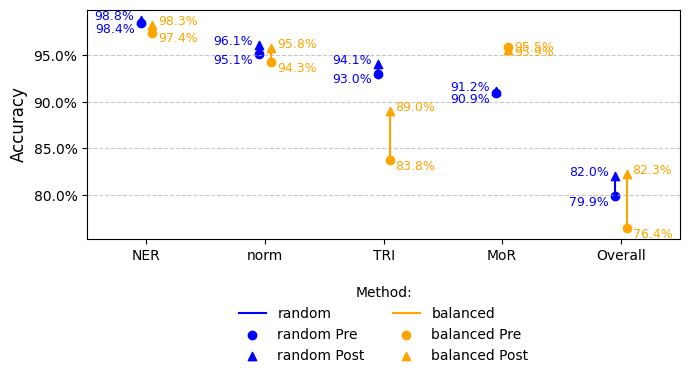

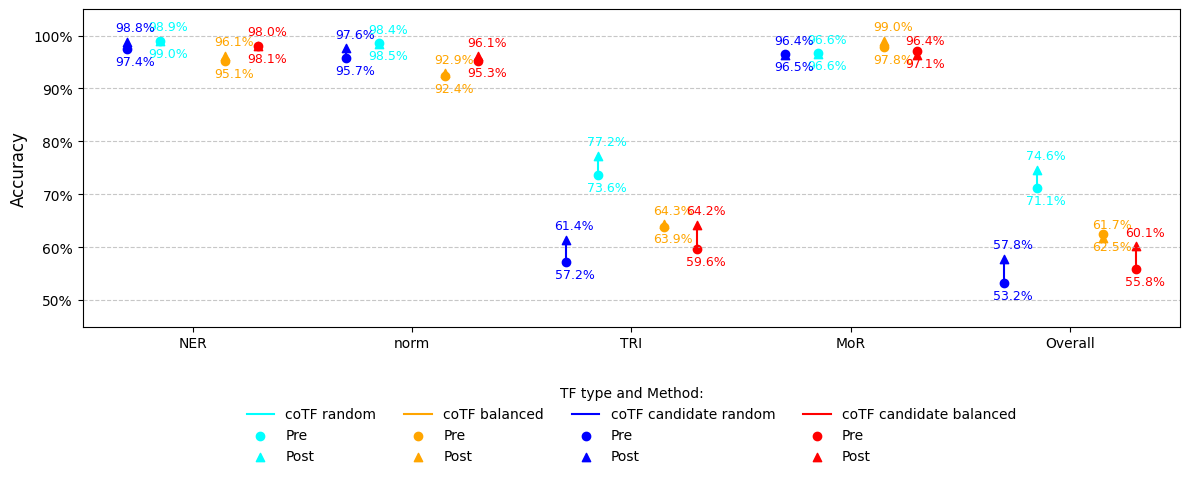

In [11]:
def make_validation_dotplot(results_table, TF_type = 'dbTF', y_sep = 0):

    XXTF_results_table = results_table[results_table['tf_type'] == TF_type]

    # Create the improved dot plot
    fig, ax = plt.subplots(figsize=(7, 4))

    cols = ['NER', 'norm', 'TRI', 'MoR', 'Overall']
    for i, col in enumerate(cols):

        # Add vertical lines for random and balanced
        for method, sep, color, orientation in [('random', -0.05, 'blue', 'right'), ('balanced', 0.05, 'orange', 'left')]: 

            # Get values for random and balanced for pre and post
            values = {}
            for pre_post in ['pre', 'post']:
                values[pre_post] = XXTF_results_table[(XXTF_results_table['method'] == method) & (XXTF_results_table['validation stage'] == pre_post)][col].values[0]

            ax.plot([i + sep, i + sep], [values['pre'], values['post']], color=color, label=method if i == 0 else "")
            ax.scatter([i + sep], [values['pre']], color=color, marker='o', label=f'{method} Pre' if i == 0 else "")
            ax.scatter([i + sep], [values['post']], color=color, marker='^', label=f'{method} Post' if i == 0 else "")

            # Add value labels next to the dots
            ax.text(i + sep*2, values['pre']-0.01-y_sep, f"{values['pre']:.1%}", fontsize=9, color=color, ha=orientation)
            ax.text(i + sep*2, values['post']+y_sep, f"{values['post']:.1%}", fontsize=9, color=color, ha=orientation)

    # Customize plot appearance
    ax.set_xticks(range(len(cols)))
    ax.set_xticklabels(cols)
    ax.set_ylabel('Accuracy', fontsize=12)
    ax.set_xlim(-0.5, len(cols) - 0.5)
    # ax.set_ylim(0.7, 1.0)
    ax.yaxis.set_major_formatter(mtick.PercentFormatter(1.0))
    # ax.set_title('Pre- and Post-Processing Accuracy: Random vs Balanced Sampling', fontsize=14)
    ax.legend(title='Method:', loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=2, fontsize=10, frameon=False)

    # Add gridlines for readability
    ax.grid(axis='y', linestyle='--', alpha=0.7)

    plt.tight_layout()
    plt.show()

def make_coTF_validation_dotplot(results_table, y_sep = 0.03):

    # Create the improved dot plot
    fig, ax = plt.subplots(figsize=(12, 5))

    cols = ['NER','norm',  'TRI', 'MoR', 'Overall']

    for TF_type, x_sep in [('coTF', 0.15), ('coTF candidate', 0.3)]:

        XXTF_results_table = results_table[results_table['tf_type'] == TF_type]

        for i, col in enumerate(cols):

            # Add vertical lines for random and balanced
            for method, sep, orientation in [('random', -x_sep, 'right'), ('balanced', x_sep, 'left')]: 

                if TF_type == 'coTF':
                    color = 'aqua' if method == 'random' else 'orange'
                else:
                    color = 'blue' if method == 'random' else 'red'

                # Get values for random and balanced for pre and post
                values = {}
                for pre_post in ['pre', 'post']:
                    values[pre_post] = XXTF_results_table[(XXTF_results_table['method'] == method) & (XXTF_results_table['validation stage'] == pre_post)][col].values[0]

                ax.plot([i + sep, i + sep], [values['pre'], values['post']], color=color, label=f"{TF_type} {method}" if i == 0 else "")
                ax.scatter([i + sep], [values['pre']], color=color, marker='o', label=f'Pre' if i == 0 else "")
                ax.scatter([i + sep], [values['post']], color=color, marker='^', label=f'Post' if i == 0 else "")

                # Add value labels next to the dots
                ax.text(i + sep-0.05, values['pre']  - y_sep, f"{values['pre']:.1%}", fontsize=9, color=color)
                ax.text(i + sep-0.05, values['post'] + y_sep-0.01, f"{values['post']:.1%}", fontsize=9, color=color)

    # Customize plot appearance
    ax.set_xticks(range(len(cols)))
    ax.set_xticklabels(cols)
    ax.set_ylabel('Accuracy', fontsize=12)
    ax.set_xlim(-0.5, len(cols) - 0.5)
    ax.set_ylim(0.45, 1.05)
    ax.yaxis.set_major_formatter(mtick.PercentFormatter(1.0))
    # ax.set_title('Pre- and Post-Processing Accuracy: Random vs Balanced Sampling', fontsize=14)
    ax.legend(title='TF type and Method:', loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=4, fontsize=10, frameon=False)

    # Add gridlines for readability
    ax.grid(axis='y', linestyle='--', alpha=0.7)

    plt.tight_layout()
    plt.show()

TRI_results_table = TRI_validation_results_table(validated_df).T.reset_index()
make_validation_dotplot(TRI_results_table)
make_coTF_validation_dotplot(TRI_results_table)

## 3.2. The ExTRI2 resource

In [12]:
def split_in_dbTF_coTF_coTF_cand(ExTRI2_df):
    m_dbTF = ExTRI2_df['TF_type'].str.contains('dbTF')
    m_coTF = ExTRI2_df['TF_type'].apply(lambda x: 'coTF' in set(x.split(';'))) & ~m_dbTF
    m_coTF_cand = ExTRI2_df['TF_type'].str.contains('coTF candidate') & ~m_dbTF & ~m_coTF

    dbTF_df = ExTRI2_df[m_dbTF]
    coTF_df = ExTRI2_df[m_coTF]
    coTF_cand_df = ExTRI2_df[m_coTF_cand]

    # Check if the split was done correctly
    assert len(ExTRI2_df) == len(dbTF_df) + len(coTF_df) + len(coTF_cand_df)

    return dbTF_df, coTF_df, coTF_cand_df    

dbTF_df, coTF_df, coTF_cand_df = split_in_dbTF_coTF_coTF_cand(ExTRI2_df)

In [13]:
# TABLES 1, 2
def table_1(ExTRI2_df, dbTF_df, coTF_df, coTF_cand_df):

    h3("Table 1")

    analysis_dfs = []
    for df, name in [(ExTRI2_df, 'Total'), (dbTF_df, 'dbTF'), (coTF_df, 'coTF'), (coTF_cand_df, 'coTF candidate')]:

        analytics = {}
        analytics['TRI-sentences'] = f"{len(df):,}"

        for mor in ['UNDEFINED', 'ACTIVATION', 'REPRESSION']:
            analytics[mor] = f"{len(df[df['MoR'] == mor]):,} ({len(df[df['MoR'] == mor])/len(df):.2%})"
        
        analytics['TG is not normalized'] = f"{(df['TG Id'].isna()).sum():,} ({(df['TG Id'].isna()).sum() / len(df):.2%})"
        analytics['Unique TRIs'] = f"{df['TRI Id'].nunique():,}"

        for T in ['TF', 'TG']:
            analytics[f'Unique {T} IDs'] = f"{df[f'{T} Id'].nunique():,}"
            analytics[f'Unique human {T} IDs'] = f"{df[df[f'{T} TaxID'] == '9606'][f'{T} Id'].nunique():,}"

        diff_species_m = df['TF TaxID'].apply(lambda x: set(x.split(';'))) != df['TG TaxID'].apply(lambda x: set(x.split(';')))
        analytics['TF & TG from different species'] = f"{diff_species_m.sum():,} ({diff_species_m.sum() / len(df):.2%})"

        # Convert the analytics dictionary to a DataFrame and add it to the list
        analysis_df = pd.DataFrame.from_dict(analytics, orient='index', columns=[name])
        analysis_dfs.append(analysis_df)

    display(pd.concat(analysis_dfs, axis=1))

def table_2(final_df, dbTF_df):

    # Obtained from other sources
    all_pmids = 38_776_000
    has_gene_entities = 6_507_211

    # Get the number of PMIDs in candidate sentences
    candidate_sents = pd.read_csv(config['raw_ExTRI2_p'], sep='\t', header=1, chunksize=1_000_000, keep_default_na=False)
    candidate_PMIDs = set()
    for chunk in candidate_sents:
        PMIDs = chunk['#SentenceID'].apply(lambda row: row.split(':')[1])
        candidate_PMIDs.update(PMIDs)

    has_TRIs = final_df['PMID'].nunique()
    has_dbTF_TRIs = dbTF_df['PMID'].nunique()

    h3("Table 2")
    analytics = {}
    analytics['All PMIDs'] = f"{all_pmids:,}"
    analytics['Has gene entities'] = f"{has_gene_entities:,} ({has_gene_entities / all_pmids:.2%})"
    analytics['Has candidate sentences'] = f"{len(candidate_PMIDs):,} ({len(candidate_PMIDs) / all_pmids:.2%})"
    analytics['Has TRIs'] = f"{has_TRIs:,} ({has_TRIs / all_pmids:.2%})"
    analytics['Has dbTF TRIs'] = f"{has_dbTF_TRIs:,} ({has_dbTF_TRIs / all_pmids:.2%})"

    analysis_df = pd.DataFrame.from_dict(analytics, orient='index', columns=['Num sentences'])
    # analysis_df.to_excel('tables_figs/table_1.xlsx')
    display(analysis_df)

table_1(ExTRI2_df, dbTF_df, coTF_df, coTF_cand_df)
table_2(ExTRI2_df, dbTF_df)

<h3>Table 1</h3>

,Total,dbTF,coTF,coTF candidate
TRI-sentences,"873,655","443,319","94,221","336,115"
UNDEFINED,"255,279 (29.22%)","142,581 (32.16%)","27,984 (29.70%)","84,714 (25.20%)"
ACTIVATION,"436,978 (50.02%)","217,345 (49.03%)","41,322 (43.86%)","178,311 (53.05%)"
REPRESSION,"181,398 (20.76%)","83,393 (18.81%)","24,915 (26.44%)","73,090 (21.75%)"
TG is not normalized,0 (0.00%),0 (0.00%),0 (0.00%),0 (0.00%)
Unique TRIs,"286,265","141,915","36,049","108,301"
Unique TF IDs,"7,118","3,313",925,"2,880"
Unique human TF IDs,"3,493","1,609",500,"1,384"
Unique TG IDs,"26,012","20,571","9,921","17,484"
Unique human TG IDs,"13,685","11,059","5,970","9,483"


<h3>Table 2</h3>

,Num sentences
All PMIDs,"38,776,000"
Has gene entities,"6,507,211 (16.78%)"
Has candidate sentences,"1,618,959 (4.18%)"
Has TRIs,"310,345 (0.80%)"
Has dbTF TRIs,"167,527 (0.43%)"


<h3>Figure 2</h3>

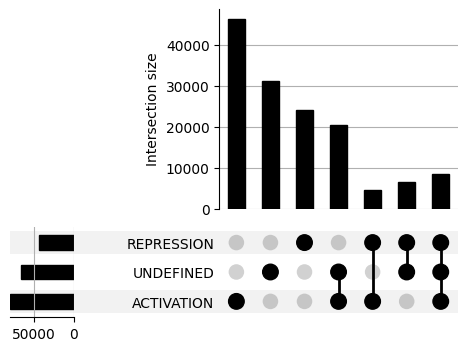

<h3>Table S1</h3>

,Counts
ACTIVATION,"46,492 (32.76%)"
REPRESSION,"24,164 (17.03%)"
UNDEFINED,"31,139 (21.94%)"
"ACTIVATION,REPRESSION","4,591 (3.24%)"
"ACTIVATION,UNDEFINED","20,508 (14.45%)"
"REPRESSION,UNDEFINED","6,609 (4.66%)"
"ACTIVATION,REPRESSION,UNDEFINED","8,412 (5.93%)"
1 MoR,"101,795 (71.73%)"
2 MoR,"31,708 (22.34%)"
3 MoR,"8,412 (5.93%)"


In [14]:
# FIGURE 2 & TABLE S1
def figure_2(df):
    # 1. Get the sets of TRIs for each MoR

    # Create a set of TRIs for each MoR
    A_set = set(df[df["MoR"] == 'ACTIVATION']['TRI Id'])
    R_set = set(df[df["MoR"] == 'REPRESSION']['TRI Id'])
    U_set = set(df[df["MoR"] == 'UNDEFINED']['TRI Id'])
    # 2. Get the union of these sets
    MoR_listoflists = [
        ['ACTIVATION'], ['REPRESSION'], ['UNDEFINED'],
        ['ACTIVATION', 'REPRESSION'],
        ['ACTIVATION', 'UNDEFINED'],
        ['REPRESSION', 'UNDEFINED'],
        ['ACTIVATION', 'REPRESSION', 'UNDEFINED']
    ]
    MoR_counts = [
        len(A_set - R_set - U_set), 
        len(R_set - A_set - U_set), 
        len(U_set - R_set - A_set),
        len((A_set & R_set) - U_set),
        len((A_set & U_set) - R_set),
        len((U_set & R_set) - A_set),
        len(A_set & R_set & U_set),    
    ]

    # Ignore warnings for upsetplot: it has a lot (library seems like is not updated)
    warnings.filterwarnings('ignore')
    example = upsetplot.from_memberships(MoR_listoflists, data=MoR_counts)
    upsetplot.plot(example)  # doctest: +SKIP
    h3("Figure 2")
    # plt.title("")
    plt.show()
    warnings.filterwarnings('default')

    return MoR_counts, MoR_listoflists

def table_S1(MoR_counts, MoR_listoflists):
    h3("Table S1")
    MoR_counts_table = {}
    for label, count in zip(MoR_listoflists, MoR_counts):
        MoR_counts_table[",".join(label)] = count

    MoR_counts_table['1 MoR'] = sum([MoR_counts_table[MoR] for MoR in ['ACTIVATION', 'REPRESSION', 'UNDEFINED']])
    MoR_counts_table['2 MoR'] = sum([MoR_counts_table[MoR] for MoR in ['ACTIVATION,REPRESSION', 'ACTIVATION,UNDEFINED', 'REPRESSION,UNDEFINED']])
    MoR_counts_table['3 MoR'] = MoR_counts_table['ACTIVATION,REPRESSION,UNDEFINED']
    TOTAL = sum([MoR_counts_table[f'{n} MoR'] for n in range(1, 4)])

    for key, value in MoR_counts_table.items():
        MoR_counts_table[key] = f"{value:,} ({value / TOTAL:.2%})"

    display(pd.DataFrame.from_dict(MoR_counts_table, orient='index', columns=['Counts']))

MoR_counts, MoR_listoflists = figure_2(dbTF_df)
table_S1(MoR_counts, MoR_listoflists)

24512 (2.81%) sentences are not considered in the analysis as their TF/TG is mapped to +1 ID
There are 0 human TFs and 820 human TGs in ExTRI2 that are not found in the all_human_genes df.
There are 830 human genes in ExTRI2 that are not found in the all_human_genes df (thus, outdated IDs)
They appear in 2608 rows, which are excluded from the TG distribution analysis, but kept for the rest of analysis.


Number of genes retrieved by category, considering direct human, and mouse/rat orthologs

,human,orthologs,unique,orth.unique,% uniq.,% orth.uniq.
Total,299677,439589,10195,11926,5.3%,10.7%
PROTEIN_CODING,289902,418886,9210,10208,44.7%,49.6%
ncRNA,8107,8531,807,684,3.7%,3.1%
PSEUDO,820,23,107,11,0.6%,0.1%
OTHER,728,0,37,0,4.4%,0.0%
snoRNA,21,9,10,7,0.8%,0.6%
tRNA,43,0,8,0,1.2%,0.0%
snRNA,30,22,7,5,4.2%,3.0%
BIOLOGICAL_REGION,15,0,6,0,0.0%,0.0%
rRNA,1,0,1,0,0.1%,0.0%


<span style='color:red'>There are 2 dbTFs that are non considered to be protein-coding, but are kept in the analysis.

,NCBI GeneID,Symbol,Gene Type,Taxonomic Name,Description
11907,100288711,DUX4L9,PSEUDO,Homo sapiens,double homeobox ...
17113,58160,NFE4,ncRNA,Homo sapiens,"nuclear factor, ..."


Number of retrieved human dbTFs

,unique,%
all considered,1788,100.0%
retrieved directly,1276,71.4%
retrieved (including orthologs),1337,74.8%


<h3>Figure 3</h3>

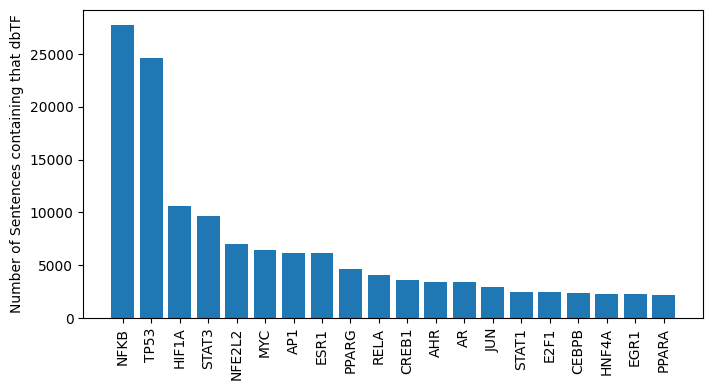

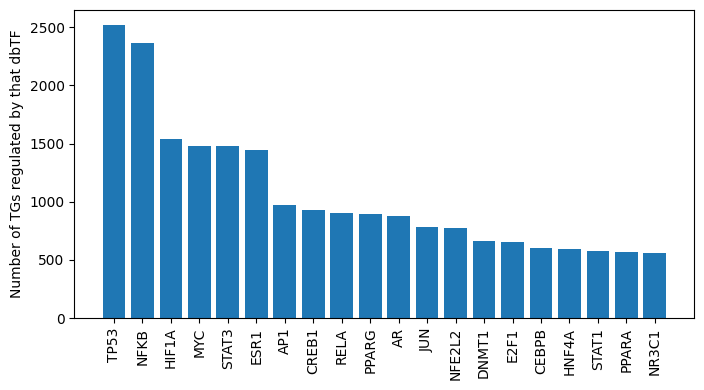

In [15]:
def load_all_human_genes():
    # Load all human TGs
    # downloaded from: https://www.ncbi.nlm.nih.gov/datasets/gene/taxon/9606/
    all_human_genes = pd.read_csv(config['all_human_TGs_p'], sep='\t', header=0, dtype=str)
    all_human_genes = all_human_genes[['NCBI GeneID', 'Symbol', 'Gene Type', 'Taxonomic Name', 'Description']]
    all_human_genes.loc[all_human_genes['Gene Type'].isna(), 'Gene Type'] = 'nan'

    # Add AP1 and NFKB complexes
    all_human_genes = pd.concat([all_human_genes, pd.DataFrame({
        'NCBI GeneID': ['Complex:AP1', 'Complex:NFKB'], 
        'Symbol': ['AP1', 'NFKB'],
        'Description': ['', ''],
        'Taxonomic Name': ['Homo sapiens', 'Homo sapiens'],
        'Gene Type': ['PROTEIN_CODING', 'PROTEIN_CODING'],
        })], ignore_index=True)
    
    # Ensure the data is expected: all human, no duplicate IDs
    assert all_human_genes['Taxonomic Name'].nunique() == 1
    assert all_human_genes['Taxonomic Name'].unique()[0] == 'Homo sapiens'
    assert (all_human_genes['NCBI GeneID'].duplicated()).sum() == 0 

    return all_human_genes

def display_TG_distribution(dbTF_df: pd.DataFrame, all_human_genes: pd.DataFrame) -> None:
    '''Display how many TGs we have retrieved'''

    # Get human TGs
    human_dbTF_df = dbTF_df[(dbTF_df['TG TaxID'] == '9606')] 

    m_TG_id = human_dbTF_df['TG Id'].isin(all_human_genes['NCBI GeneID'])
    print(f"There are {len(human_dbTF_df[~m_TG_id]['TG Id'].unique())} human genes in ExTRI2 that are not found in the all_human_genes df (thus, outdated IDs)")
    print(f"They appear in {(~m_TG_id).sum()} rows, which are excluded from the TG distribution analysis, but kept for the rest of analysis.")
    human_dbTF_df = human_dbTF_df[m_TG_id]

    # Initialise dict    
    TG_types = {}
    TG_types['Total'] = {
        'human': len(human_dbTF_df),
        'orthologs': len(dbTF_df),
        'unique': len(human_dbTF_df['TG Id'].unique()),
        'orth.unique': len(dbTF_df['TG_human_Id'].unique()),
        '% uniq.': f"{len(human_dbTF_df['TG Id'].unique()) / len(all_human_genes):.1%}",
        '% orth.uniq.': f"{len(dbTF_df['TG Id'].unique()) / len(all_human_genes):.1%}"
    }

    # Fill in dict
    for gene_type in all_human_genes['Gene Type'].unique():
        human_genes_of_gene_type = all_human_genes[all_human_genes['Gene Type'] == gene_type]['NCBI GeneID']

        human_sents = human_dbTF_df[human_dbTF_df['TG Id'].isin(human_genes_of_gene_type)]
        ortholog_sents = dbTF_df[dbTF_df['TG_human_Id'].isin(human_genes_of_gene_type)]
        TG_types[gene_type] = {
            'human': len(human_sents),
            'orthologs': len(ortholog_sents),
            'unique': len(human_sents['TG Id'].unique()),
            'orth.unique': len(ortholog_sents['TG_human_Id'].unique()),
        }
        TG_types[gene_type]['% uniq.']      = f"{TG_types[gene_type]['unique'] / len(human_genes_of_gene_type):.1%}"
        TG_types[gene_type]['% orth.uniq.'] = f"{TG_types[gene_type]['orth.unique'] / len(human_genes_of_gene_type):.1%}"


    # Convert to dataframe & display
    md("Number of genes retrieved by category, considering direct human, and mouse/rat orthologs")
    display(pd.DataFrame.from_dict(TG_types, orient='index').sort_values(by='unique', ascending=False))

def display_TF_distribution(dbTF_df: pd.DataFrame, all_human_genes: pd.DataFrame, dbTFs_set: set) -> None:

    human_dbTF_df = dbTF_df[(dbTF_df['TF TaxID'] == '9606')] 

    # Get all retrieved human dbTFs
    retrieved_TF_IDs = set(human_dbTF_df['TF Id'])

    # Ensure retrieved dbTFs are in the original list of dbTFs
    assert retrieved_TF_IDs.issubset(dbTFs_set), "Some dbTFs are not part of the original dbTFs list: {}".format(retrieved_TF_IDs - dbTFs_set)

    # Ensure they are all in the list of human genes
    assert retrieved_TF_IDs.issubset(set(all_human_genes['NCBI GeneID'])), "Some dbTFs are not part of the NCBI df"

    # Check if they are all protein-coding genes
    non_protein_coding_dbTFs = retrieved_TF_IDs - set(all_human_genes[all_human_genes['Gene Type'] == 'PROTEIN_CODING']['NCBI GeneID'])
    md(f"<span style='color:red'>There are {len(non_protein_coding_dbTFs)} dbTFs that are non considered to be protein-coding, but are kept in the analysis.")
    display(all_human_genes[all_human_genes['NCBI GeneID'].isin(non_protein_coding_dbTFs)])

    # Get the set of human dbTFs
    human_dbTFs_set = dbTFs_set.intersection(set(all_human_genes['NCBI GeneID']))

    # Prepare the dataframe to display, with counts and percentages
    human_dbTF_summary = {
        category: {
            "unique": count,
            "%": f"{count / len(human_dbTFs_set):.1%}"
        }
        for category, count in {
            'all considered': len(human_dbTFs_set),
            'retrieved directly': len(human_dbTF_df['TF Id'].unique()),
            'retrieved (including orthologs)': len(dbTF_df[~dbTF_df['TF_human_Id'].str.contains(';')]['TF_human_Id'].unique())
        }.items()
    }

    md("Number of retrieved human dbTFs")
    display(pd.DataFrame.from_dict(human_dbTF_summary, orient='index'))

def figure_3(human_dbTF_df):
    '''Plot the most common dbTFs'''

    h3("Figure 3")

    # Plot the most common dbTFs
    def plot_counts(df, ylabel):
        counts = df['TF Symbol'].value_counts()
        plt.figure(figsize=(8,4))
        plt.bar(counts[:20].index, counts[:20])
        plt.xticks(rotation='vertical')
        plt.ylabel(ylabel)

    # Plot dbTFs that appear in most sentences
    plot_counts(human_dbTF_df, "Number of Sentences containing that dbTF")
    
    # Plot dbTFs that are associated with the most TGs
    unique_TRIs = human_dbTF_df.drop_duplicates(subset='TRI Id', keep='first')
    plot_counts(unique_TRIs, "Number of TGs regulated by that dbTF")
    plt.show()    

def human_TF_TG_analysis(ExTRI2_df: pd.DataFrame, all_TFs_df: pd.DataFrame) -> None:
    '''Check the category of the found TGs'''

    # Load dataframe of all human genes
    all_human_genes = load_all_human_genes()

    # Show how many sentences have multiple mappings
    multiple_mapped = ((ExTRI2_df['TF Id'].str.contains(';')) | (ExTRI2_df['TG Id'].str.contains(';'))).sum()
    print(f"{multiple_mapped} ({multiple_mapped / len(ExTRI2_df):.2%}) sentences are not considered in the analysis as their TF/TG is mapped to +1 ID")

    # Filter ExTRI2 by only those containing human dbTFs (ignore those mapped to +1 ids)
    dbTF_df = ExTRI2_df[ExTRI2_df['TF_type'] == 'dbTF']
    human_dbTF_df = dbTF_df[(dbTF_df['TG TaxID'] == '9606') & (dbTF_df['TF TaxID'] == '9606')] 

    # Discard human TGs that are not found in the NCBI human genes df
    m_TF_id = human_dbTF_df['TF Id'].isin(all_human_genes['NCBI GeneID'])
    not_found_human_TF = human_dbTF_df[~m_TF_id]['TF Id'].unique()

    m_TG_id = human_dbTF_df['TG Id'].isin(all_human_genes['NCBI GeneID'])
    not_found_human_TG = human_dbTF_df[~m_TG_id]['TG Id'].unique()

    print(f"There are {len(not_found_human_TF)} human TFs and {len(not_found_human_TG)} human TGs in ExTRI2 that are not found in the all_human_genes df.")

    # Get set of all considered dbTFs
    dbTFs_set = set(all_TFs_df[all_TFs_df['updated TF type'] == 'dbTF']['Gene ID']) | {'Complex:NFKB', 'Complex:AP1'}

    # Show how many TGs and TFs we've obtained
    display_TG_distribution(dbTF_df, all_human_genes)
    display_TF_distribution(dbTF_df, all_human_genes, dbTFs_set)

    # Plot counts
    figure_3(human_dbTF_df)

    return

human_TF_TG_analysis(ExTRI2_df, all_TFs_df)

## Supp. File. Post-processing

**Post-processing and normalization scripts** in [postprocessing.py](../scripts/postprocessing/postprocessing.py) and [postprocessing_checkings.ipynb](../scripts/postprocessing/postprocessing_checkings.ipynb)


## 2.7, 2.8, 3.3. CollecTRI

In [27]:
# LOAD DATASETS
collectri = pd.read_csv("../data/paper_tables/CollecTRI2.tsv.gz", sep='\t', dtype="str", skiprows=1)
collectri_regulome = pd.read_csv("../data/paper_tables/CollecTRI2-regulome.tsv.gz", sep='\t', dtype="str", skiprows=1)

# Get TF-related data
all_TFs_df = (all_TFs_df[~all_TFs_df['updated TF type'].isna()]
              .drop(columns=['original TF type'])
              .rename(columns={'updated TF type': 'TF type'})
)
TFs_in_ExTRI2 = pd.read_csv("../data/paper_tables/TFs_in_ExTRI2.tsv", sep="\t", dtype="str")

# Check all_TFs_df & TFs_in_ExTRI2 are consistent
cols = ['Gene ID', 'TF type']
assert (
    TFs_in_ExTRI2[cols].sort_values(by=cols).reset_index(drop=True)
    .equals(
        all_TFs_df[all_TFs_df['In ExTRI2']][cols]
        .sort_values(by=cols).reset_index(drop=True)
    )
), 'all_TFs_df & TFs_in_ExTRI2 do not match.'

# Get all human genes
def load_all_human_genes():
    # Load all human TGs
    # downloaded from: https://www.ncbi.nlm.nih.gov/datasets/gene/taxon/9606/
    all_human_genes = pd.read_csv(config['all_human_TGs_p'], sep='\t', header=0, dtype=str)
    all_human_genes = all_human_genes[['NCBI GeneID', 'Symbol', 'Gene Type', 'Taxonomic Name', 'Description']]
    all_human_genes.loc[all_human_genes['Gene Type'].isna(), 'Gene Type'] = 'nan'

    # Add AP1 and NFKB complexes
    all_human_genes = pd.concat([all_human_genes, pd.DataFrame({
        'NCBI GeneID': ['Complex:AP1', 'Complex:NFKB'], 
        'Symbol': ['AP1', 'NFKB'],
        'Description': ['', ''],
        'Taxonomic Name': ['Homo sapiens', 'Homo sapiens'],
        'Gene Type': ['PROTEIN_CODING', 'PROTEIN_CODING'],
        })], ignore_index=True)
    
    # Ensure the data is expected: all human, no duplicate IDs
    assert all_human_genes['Taxonomic Name'].nunique() == 1
    assert all_human_genes['Taxonomic Name'].unique()[0] == 'Homo sapiens'
    assert (all_human_genes['NCBI GeneID'].duplicated()).sum() == 0 

    return all_human_genes

all_human_genes = load_all_human_genes()

In [28]:
# EXTRI RELEVANT COLUMNS AND ROWS NOT INCLUDED IN COLLECTRI / HUMAN ANALYSIS
display(ExTRI2_df[[c for c in ExTRI2_df.columns if ("human" in c) or ("HGNC" in c)]].head(2))

# Get the proportion of ExTRI2 sentences not considered for human analysis or CollecTRI
to_discard_m = (
     ExTRI2_df['TF_human_symbol'].str.contains(';') | 
    (ExTRI2_df['TF_human_symbol'] == 'None') | (ExTRI2_df['TF_human_symbol'].isna()) | 
     ExTRI2_df['TG_human_symbol'].str.contains(';') | 
    (ExTRI2_df['TG_human_symbol'] == 'None') | (ExTRI2_df['TG_human_symbol'].isna())
)
print(f"ExTRI2 sentences not included in CollecTRI & not considered for human analysis: {to_discard_m.mean():.2%}")

# Ensure all "TF_human_symbol" are in all_human_genes
m = ~ExTRI2_df['TF_human_symbol'].isin(all_human_genes['Symbol']) & ~to_discard_m
assert m.sum() == 0, f"{m.sum()} TFs are not in all_human_genes"

,TF_human_Id,TF_human_symbol,TF_HGNC_Id,TG_human_Id,TG_human_symbol,TG_HGNC_Id
0,51142,CHCHD2,HGNC:21645,84572,GNPTG,HGNC:23026
1,51085,MLXIPL,HGNC:12744,58526;10628,MID1IP1;TXNIP,HGNC:20715;HGNC:...


ExTRI2 sentences not included in CollecTRI & not considered for human analysis: 4.63%


In [29]:
# GET PERCENTAGE OF COLLECTRI TRIs WITH MOR

# --- Get data ---
# Manually separate CollecTRI columns into groups
collecTRI_cols = set(collectri.columns)
present_cols = {col for col in collecTRI_cols if 'present' in col}
sign_cols = {col for col in collecTRI_cols for var in ['Sign', 'Regulation', 'action', 'Activation'] if (var in col)} |  {'[GEREDB] Effect'}
source_cols = {col for col in collecTRI_cols if 'source' in col}

# Get all ways sign is written in CollecTRI
positive_MoRs = {'up', 'activation', 'positive', '+'}
negative_MoRs = {'down', 'repression', 'negative', '-'}
relevant_MoR_vals = positive_MoRs.union(negative_MoRs)

# --- Visual checks ---
# Print unclassified cols
remaining_cols = collecTRI_cols - present_cols - sign_cols - source_cols
print("UNCLASSIFIED COLUMNS:\n",remaining_cols)

# Print all included & excluded terms for sign:
print("\nCOLUMNS WITH SIGN:")
print(f"{'column':30} {'Included MoRs':30} {'Excluded MoRs'}")
for col in sign_cols:
    all_MoRs = {v for vals in collectri[col].unique() for v in (str(vals).split('|'))} - {'nan'}
    included_MoRs = {MoR for MoR in all_MoRs if MoR.lower() in relevant_MoR_vals}
    print(f"{col:30} {', '.join(included_MoRs):30} {', '.join(all_MoRs - included_MoRs)}")

# --- Get statistics: proportion of TRIs with positive or negative MoR ---
positive_pattern = '|'.join(map(re.escape, positive_MoRs))
negative_pattern = '|'.join(map(re.escape, negative_MoRs))

pos_mask = collectri[list(sign_cols)].apply(lambda col: col.str.lower().str.contains(positive_pattern, regex=True)).any(axis=1)
neg_mask = collectri[list(sign_cols)].apply(lambda col: col.str.lower().str.contains(negative_pattern, regex=True)).any(axis=1)

print("\nTRIS IN COLLECTRI WITH MoR INFORMATION FROM SOME SOURCE:")
print(f"Proportion with positive MoR: {pos_mask.mean():.2%}")
print(f"Proportion with negative MoR: {neg_mask.mean():.2%}")
print(f"Proportion with positive or negative MoR: {(pos_mask | neg_mask).mean():.2%}")

UNCLASSIFIED COLUMNS:
 {'[DoRothEA_A] Effect', '[CytReg] species', '[IntAct] PMID', 'Auto-regulation', '[Pavlidis2021] PMID', '[ExTRI2] Transcription Factor Type', '[TRRUST] PMID', '[SIGNOR] PMID', '[NTNU Curated] PMID', 'Transcription Factor (Associated Gene Name)', '[DoRothEA_A] PMID', '[GEREDB] PMID', '[CytReg] Year of publication', '[CytReg] Assay type', '[TFactS] Source', 'Target Gene (Associated Gene Name)', 'Lambert', 'TFClass', '[SIGNOR] Effect', '[IntAct] Method ID', 'Lovering', '[TFactS] Species', '[CytReg] PMID', '[TFactS] PMID', '[HTRI] PMID', '[DoRothEA_A] Directed', '[GOA] PMID', '#TF:TG', '[TFactS] Confidence', '[HTRI] Confidence', '[HTRI] Technique', 'GO:0003712', 'GO:0003700', '[ExTRI2] PMID', 'GO:0140223', '[Pavlidis2021] MoR'}

COLUMNS WITH SIGN:
column                         Included MoRs                  Excluded MoRs
[TFactS] Sign                  UP, DOWN                       
[TRRUST] Regulation            Repression, Activation         Unknown
[GEREDB] Effect

In [30]:
# STATISTICS ON COLLECTRI HUMAN TF COVERAGE

## --- Prepare variables ---
# Useful variable
tf_col = 'Transcription Factor (Associated Gene Name)'
tg_col = 'Target Gene (Associated Gene Name)'

# General gene sets
all_HG_symbol      = set(all_human_genes['Symbol'])
prot_cod_HG_symbol = set(all_human_genes.loc[all_human_genes['Gene Type'] == 'PROTEIN_CODING', 'Symbol'])

# TF gene sets
# TODO - all_TFs_df['human_symbol'] only contains human symbols for all_TFs_df['In ExTRI2'] == 'True'
# Instead, I'll only consider human TFs we've considered, but that might miss some. 
# Discuss what would be the correct thing to do
# all_TFs_symbol     = set(all_TFs_df['human_symbol'])
# dbTFs_symbol       = set(all_TFs_df[all_TFs_df['TF type'] == 'dbTF']['human_symbol'])
all_TFs_symbol = set(all_TFs_df[all_TFs_df['TaxID'] == '9606']['Symbol'])
dbTFs_symbol   = set(all_TFs_df[(all_TFs_df['TaxID'] == '9606') & (all_TFs_df['TF type'] == 'dbTF')]['Symbol'])

# Get masks from the datasets
prot_cod_TF_mask = collectri[tf_col].isin(prot_cod_HG_symbol)
prot_cod_TG_mask = collectri[tg_col].isin(prot_cod_HG_symbol)
dbTF_mask = collectri[tf_col].isin(dbTFs_symbol)
ExTRI2_mask = collectri['[ExTRI2] present'].notna()

# --- Only keep protein-coding genes ---
print("Discarding non-protein-coding TFs from analysis:")
print(f"""\
{(~prot_cod_TF_mask).sum()} ({(~prot_cod_TF_mask).mean():.2%}) TRIs in collecTRI have non-protein-coding TFs, including:
- {len(set(collectri[~prot_cod_TF_mask][tf_col]))} TFs from CollecTRI, {len(set(collectri[~prot_cod_TF_mask & ExTRI2_mask][tf_col]))} from ExTRI2
- {len(set(collectri[~prot_cod_TF_mask & dbTF_mask][tf_col]))} dbTFs from CollecTRI, {len(set(collectri[~prot_cod_TF_mask & ExTRI2_mask & dbTF_mask][tf_col]))} from ExTRI2
- {len(all_TFs_symbol - prot_cod_HG_symbol)}/{len(all_TFs_symbol)} of considered TFs
- {len(dbTFs_symbol - prot_cod_HG_symbol)}/{len(dbTFs_symbol)} of considered dbTFs
""")

# Discard non-protein-coding TFs from collecTRI
collecTRI_protcod = collectri[prot_cod_TF_mask]
ExTRI2_mask = collecTRI_protcod['[ExTRI2] present'].notna()
dbTF_mask = collecTRI_protcod[tf_col].isin(dbTFs_symbol)

# Get all relevant sets (TF, TG, dbTF)
collecTRI_tfs      = set(collecTRI_protcod[tf_col])
collecTRI_tgs      = set(collecTRI_protcod[tg_col])
collecTRI_dbtfs    = set(collecTRI_protcod[dbTF_mask][tf_col])
collecTRI_dbtf_tgs = set(collecTRI_protcod[dbTF_mask][tg_col])

ExTRI2_tfs         = set(collecTRI_protcod[ExTRI2_mask][tf_col])
ExTRI2_tgs         = set(collecTRI_protcod[ExTRI2_mask][tg_col])
ExTRI2_dbtfs       = set(collecTRI_protcod[ExTRI2_mask & dbTF_mask][tf_col])
ExTRI2_dbtf_tgs    = set(collecTRI_protcod[ExTRI2_mask & dbTF_mask][tg_col])

Discarding non-protein-coding TFs from analysis:
179 (0.08%) TRIs in collecTRI have non-protein-coding TFs, including:
- 11 TFs from CollecTRI, 8 from ExTRI2
- 1 dbTFs from CollecTRI, 1 from ExTRI2
- 44/3480 of considered TFs
- 34/1786 of considered dbTFs



CollecTRI2 aggregates transcriptional regulatory interactions (TRIs) from multiple publicly available resources, including ExTRI2 (222,387 total, 200,851 unique), NTNU Curated (11,358 total, 1,503 unique), TRRUST (8,391 total, 1,042 unique), GEREDB (7,695 total, 1,078 unique), TFactS (6,657 total, 2,065 unique), DoRothEA_A (6,041 total, 889 unique), SIGNOR (3,013 total, 756 unique), HTRI (2,262 total, 605 unique), GOA (2,004 total, 1,078 unique), Pavlidis2021 (1,463 total, 297 unique), CytReg (1,232 total, 188 unique), and IntAct (410 total, 233 unique). In total, CollecTRI2 contains 234,022 TRIs. Together, these datasets provide complementary and overlapping evidence of transcriptional regulation, with ExTRI2 contributing the majority of entries, while curated resources such as NTNU Curated, TRRUST, and TFactS add high-quality, manually verified interactions.

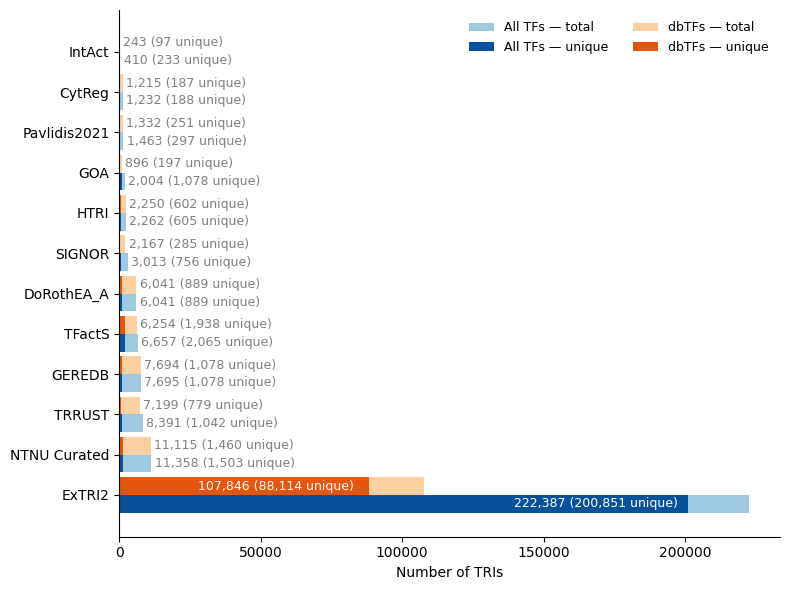

In [31]:
# TOTAL & UNIQUE TRIs PER DATASET (all TFs & dbTFs)
def plot_collectri2_grouped(CollecTRI2: pd.DataFrame, dbTFs_symbol, figsize=(9,6)):
    """
    Horizontal chart, two same-width bars per dataset:
      - All TFs (total), labeled "total (unique ...)"
      - dbTFs (total), labeled "total (unique ...)"
    Datasets are separated by a small gap.
    """

    # --- Build presence matrix with clean dataset names ---
    present_cols = [c for c in CollecTRI2.columns if 'present' in c]
    presence_df = CollecTRI2[present_cols].notna().astype(bool)
    clean_names = [re.sub(r'[\[\]]', '', c.replace(' present', '').strip()) for c in present_cols]
    presence_df.columns = clean_names

    # dbTF subset
    is_dbTF = CollecTRI2['Transcription Factor (Associated Gene Name)'].isin(dbTFs_symbol)
    presence_db = presence_df[is_dbTF]

    # --- Totals & uniques ---
    total_all = presence_df.sum()
    unique_all = pd.Series({
        c: (presence_df[c] & ~presence_df.drop(columns=[c]).any(axis=1)).sum()
        for c in presence_df.columns
    })

    total_db = presence_db.sum()
    unique_db = pd.Series({
        c: (presence_db[c] & ~presence_db.drop(columns=[c]).any(axis=1)).sum()
        for c in presence_db.columns
    })

    # Order by All TFs total (descending looks nice for horizontal)
    order = total_all.sort_values(ascending=False).index
    total_all = total_all[order]
    unique_all = unique_all[order]
    total_db  = total_db[order]
    unique_db = unique_db[order]

    # --- Positions: two bars per dataset, same height, small gap between datasets ---
    n = len(order)
    bar_height = 0.38                  # SAME for both bars
    group_gap  = 0.00                  # gap between the two bars within a dataset
    y_all = np.arange(n) * (2*bar_height + group_gap + 0.1)   # add extra space between datasets
    y_db  = y_all + bar_height + group_gap

    # --- Plot ---
    plt.figure(figsize=figsize)

    c_all_total = "#9ecae1"  # light blue
    c_all_uniq  = "#08519c"  # dark blue
    c_db_total  = "#fdd0a2"  # light orange
    c_db_uniq   = "#e6550d"  # dark orange

    bars_all = plt.barh(y_all, total_all.values, height=bar_height, label='All TFs — total', color=c_all_total)
    bars_uniq_all = plt.barh(y_all, unique_all.values, height=bar_height, label='All TFs — unique', color=c_all_uniq)
    bars_db  = plt.barh(y_db,  total_db.values,  height=bar_height, label='dbTFs — total', color=c_db_total)
    bars_uniq_db  = plt.barh(y_db,  unique_db.values,  height=bar_height, label='dbTFs — unique', color=c_db_uniq)

    # --- Labels: "total (unique …)" placed at bar end (inside if long enough) ---
    def annotate(bars, totals, uniques):
        for b, tot, uni in zip(bars, totals, uniques):
            x_end = b.get_width()
            y_mid = b.get_y() + b.get_height()/2
            txt = f"{int(tot):,} ({int(uni):,} unique)"
            # choose inside vs outside based on available space
            # (tune threshold to your data scale)
            if x_end > 15000:
                plt.text(x_end - 25000, y_mid, txt, va='center', ha='right', color='white', fontsize=9)
            else:
                plt.text(x_end + 1200, y_mid, txt, va='center', ha='left', color='gray', fontsize=9)

    annotate(bars_all, total_all.values, unique_all.values)
    annotate(bars_db,  total_db.values,  unique_db.values)

    # --- Axis / legend ---
    # Remove top and right borders
    ax = plt.gca()
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)

    # Center tick between the two bars of each dataset
    yticks = (y_all + y_db) / 2
    plt.yticks(yticks, order)
    plt.xlabel('Number of TRIs')
    # plt.title('Total and Unique TRIs per Dataset — All TFs vs dbTFs')
    plt.legend(ncol=2, frameon=False, fontsize=9)
    plt.tight_layout()

def plot_collectri2_with_uniques(CollecTRI2):
    """
    Plot total and unique TRIs per dataset.
    Label all bars outside, except ExTRI2, which is labeled inside for visibility.
    """

    # --- Compute totals and uniques ---
    present_cols = [c for c in CollecTRI2.columns if 'present' in c]

    presence_df = CollecTRI2[present_cols].notna().astype(bool)
    clean_names = [re.sub(r'[\[\]]', '', c.replace(' present', '').strip()) for c in present_cols]
    presence_df.columns = clean_names

    total_counts = presence_df.sum()
    unique_counts = {
        c: (presence_df[c] & ~presence_df[[x for x in presence_df.columns if x != c]].any(axis=1)).sum()
        for c in presence_df.columns
    }

    # --- Sort by total count ---
    order = total_counts.sort_values(ascending=True).index
    total_counts = total_counts[order]
    unique_counts = pd.Series(unique_counts)[order]

    # --- Plot ---
    plt.figure(figsize=(6, 4))
    bars_total = plt.barh(order, total_counts, color='skyblue', label='Total TRIs')
    bars_unique = plt.barh(order, unique_counts, color='steelblue', label='Unique TRIs')

    # --- Add labels ---
    for name, bar_total, bar_unique in zip(order, bars_total, bars_unique):
        total = int(bar_total.get_width())
        unique = int(bar_unique.get_width())

        # Default: label outside
        if name == "ExTRI2":
            # Place inside, right-aligned, white text
            plt.text(
                total - 40000,  # slight padding inside
                bar_total.get_y() + bar_total.get_height() / 2,
                f"{total:,} ({unique:,} unique)",
                va='center', ha='right', fontsize=9, color='white'
            )
        else:
            # Place outside, gray text
            plt.text(
                total + 3000,
                bar_total.get_y() + bar_total.get_height() / 2,
                f"{total:,} ({unique:,} unique)",
                va='center', ha='left', fontsize=9, color='gray'
            )

    plt.xlabel('Number of TRIs')
    plt.ylabel('Dataset')
    plt.legend(frameon=False, loc='lower right')
    plt.tight_layout()
    plt.show()

def markdown_collectri_paragraph(CollecTRI2):
    """
    Generates a plain-text paragraph summarizing the CollecTRI2 dataset composition.
    Automatically computes total and unique TRIs per dataset and writes it as prose.
    """

    # Select only 'present' columns
    present_cols = [c for c in CollecTRI2.columns if 'present' in c]

    # Convert to boolean (True if not NaN)
    presence_df = CollecTRI2[present_cols].notna().astype(bool)

    # Clean column names
    clean_names = [re.sub(r'[\[\]]', '', c.replace(' present', '').strip()) for c in present_cols]
    presence_df.columns = clean_names

    # Rename ExTRI → ExTRI2
    if 'ExTRI' in presence_df.columns:
        presence_df = presence_df.rename(columns={'ExTRI': 'ExTRI2'})

    # Total TRIs per dataset
    total_counts = presence_df.sum()

    # Unique TRIs per dataset
    unique_counts = {}
    for c in presence_df.columns:
        others = [x for x in presence_df.columns if x != c]
        unique_counts[c] = (presence_df[c] & ~presence_df[others].any(axis=1)).sum()

    # Total TRIs across all datasets (union)
    total_union = presence_df.any(axis=1).sum()

    # Build the text paragraph
    parts = []
    for name in total_counts.sort_values(ascending=False).index:
        total = int(total_counts[name])
        unique = int(unique_counts[name])
        parts.append(f"{name} ({total:,} total, {unique:,} unique)")

    # Join into a human-readable sentence
    text = (
        f"CollecTRI2 aggregates transcriptional regulatory interactions (TRIs) from multiple publicly available resources, "
        f"including {', '.join(parts[:-1])}, and {parts[-1]}. "
        f"In total, CollecTRI2 contains {total_union:,} TRIs. "
        f"Together, these datasets provide complementary and overlapping evidence of transcriptional regulation, "
        f"with ExTRI2 contributing the majority of entries, while curated resources such as NTNU Curated, TRRUST, and TFactS "
        f"add high-quality, manually verified interactions."
    )

    return text

md(markdown_collectri_paragraph(collectri))

# md("Total and Unique TRIs per CollecTRI2 Dataset")
# plot_collectri2_with_uniques(collectri)
# md("Total and Unique TRIs per dbTF CollecTRI2 Dataset")
# plot_collectri2_with_uniques(collectri[collectri['Transcription Factor (Associated Gene Name)'].isin(dbTFs_symbol)])

plot_collectri2_grouped(collectri, dbTFs_symbol, (8, 6))

Overlap of “Present” TRIs Across CollecTRI2 Sources

<Figure size 800x500 with 0 Axes>

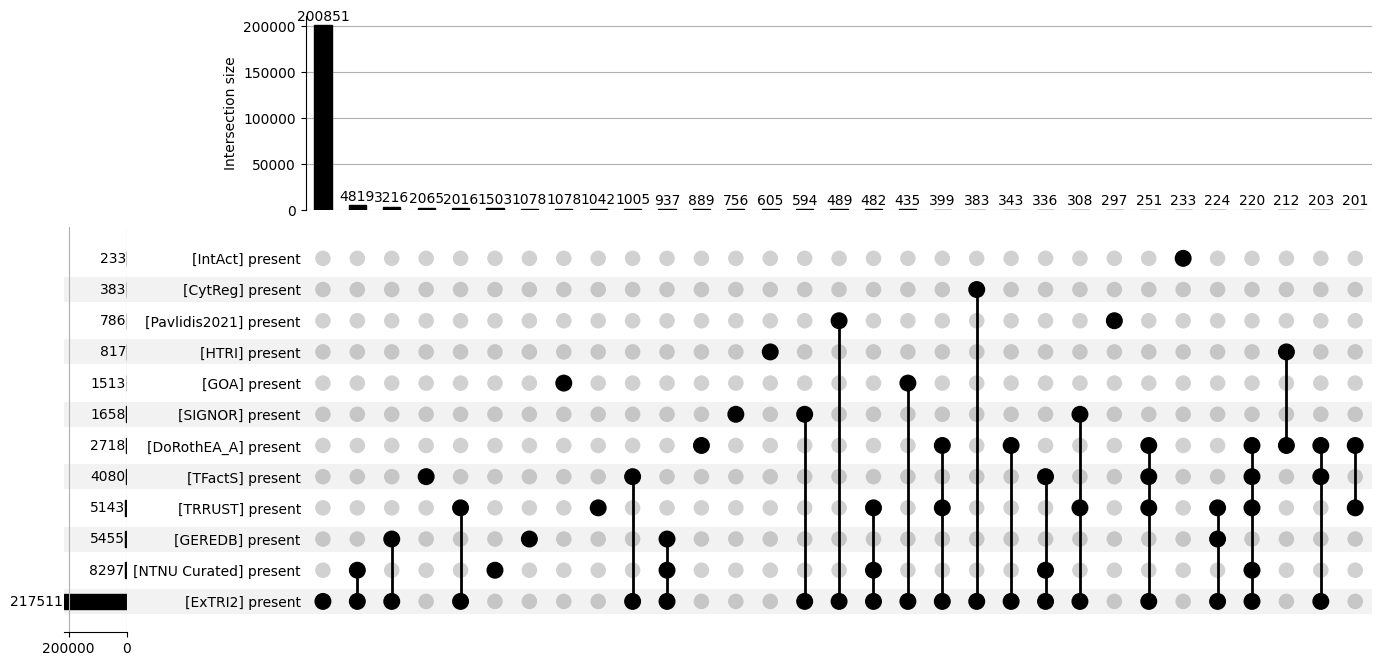

Overlap of “Present” TRIs Across dbTF-set CollecTRI2 Sources

<Figure size 800x500 with 0 Axes>

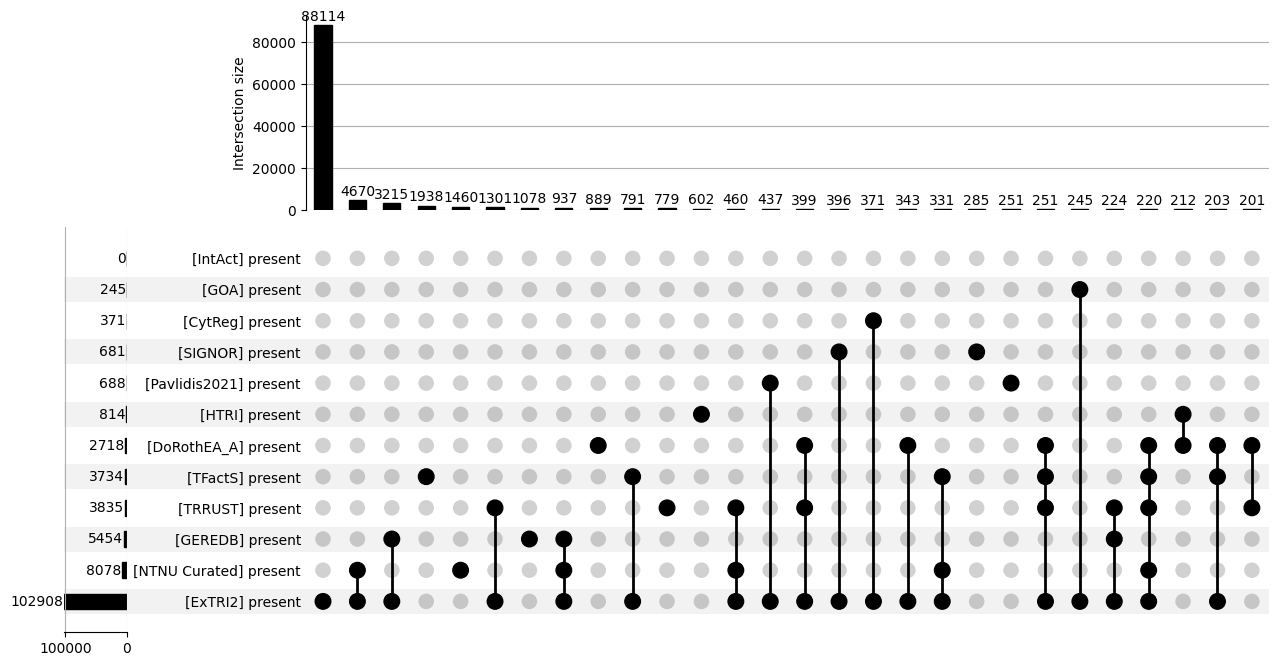

In [32]:
# MAKE UPSETPLOT FOR >200 TRIs (Collectri & dbTF-collecTRI)
def figure_collectri_overlap(CollecTRI2):
    """
    Creates a readable UpSet plot showing overlaps between TRIs present in different CollecTRI2 sources.
    Filters out very small or rare combinations.
    """

    # Select 'present' columns
    present_cols = [c for c in CollecTRI2.columns if 'present' in c]

    # Convert to boolean
    presence_df = CollecTRI2[present_cols].notna().astype(bool)

    # Count unique presence combinations
    combination_counts = presence_df.value_counts().sort_values(ascending=False)

    # 🧹 Filter: keep only the top combinations or those above a certain count threshold
    combination_counts = combination_counts[combination_counts > 200]  # show only combos with >100 TRIs
    # alternatively, use top N combos:
    # combination_counts = combination_counts.head(20)

    # Ignore warnings
    warnings.filterwarnings('ignore')

    # Plot
    plt.figure(figsize=(8, 5))
    upsetplot.plot(
        combination_counts,
        sort_by='cardinality',
        show_counts=True
    )
    plt.tight_layout()
    plt.show()

    warnings.filterwarnings('default')

md('Overlap of “Present” TRIs Across CollecTRI2 Sources')
figure_collectri_overlap(collectri)
md('Overlap of “Present” TRIs Across dbTF-set CollecTRI2 Sources')
figure_collectri_overlap(collectri[collectri[tf_col].isin(dbTFs_symbol)])

/home/cdt_wsl/git/ExTRI2_gits/ExTRI2/.general_env/lib/python3.10/site-packages/matplotlib_venn/layout/venn3/pairwise.py:169: UserWarning: Bad circle positioning.
  warnings.warn("Bad circle positioning.")


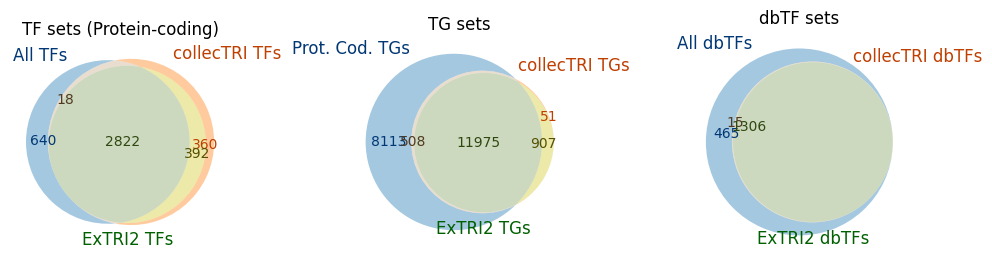

<Figure size 800x500 with 0 Axes>

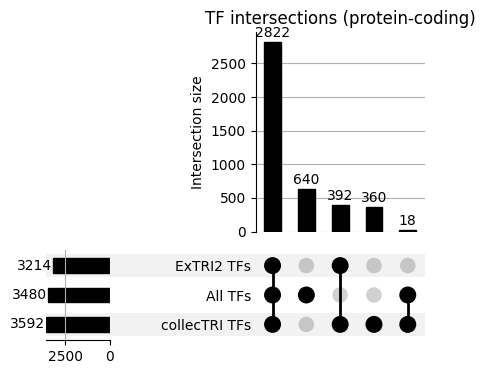

<Figure size 800x500 with 0 Axes>

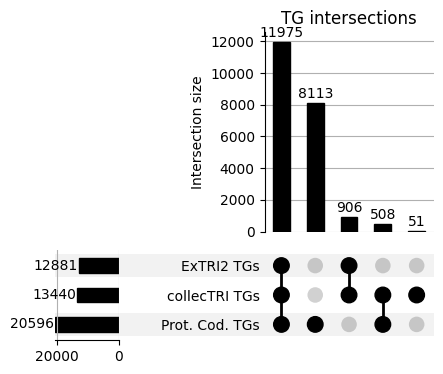

<Figure size 800x500 with 0 Axes>

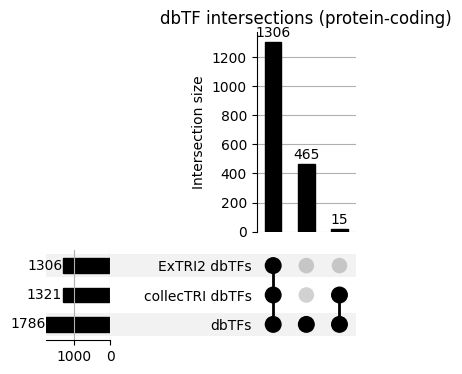

In [33]:
# % OF HUMAN TFs/TGs IN COLLECTRI

# one shared palette: [reference/universe, collecTRI, ExTRI2]
BASE_COLORS = ('#1f77b4', '#ff7f0e', '#2ca02c')  # blue, orange, green

def darken(c, amt=0.5):
    r,g,b = mcolors.to_rgb(c); return (max(0,r-amt), max(0,g-amt), max(0,b-amt))
def blend(colors):
    arr = np.array([mcolors.to_rgb(c) for c in colors]); return tuple(arr.mean(axis=0))

def colorize(v, base):
    # color set labels
    for i, lbl in enumerate(v.set_labels):
        if lbl: lbl.set_color(darken(base[i], 0.25))
    # color numbers (subset labels) using blended hues, then darken
    id2sets = {'100':[0],'010':[1],'001':[2],'110':[0,1],'101':[0,2],'011':[1,2],'111':[0,1,2]}
    for sid, idxs in id2sets.items():
        lbl = v.get_label_by_id(sid)
        if lbl: lbl.set_color(darken(blend([base[i] for i in idxs]), 0.25))

fig, axes = plt.subplots(1, 3, figsize=(10, 4))

# TF venn: [All TFs, collecTRI TFs, ExTRI2 TFs]
v_tf = venn3([all_TFs_symbol, collecTRI_tfs, ExTRI2_tfs],
             set_labels=['All TFs', 'collecTRI TFs', 'ExTRI2 TFs'],
             set_colors=BASE_COLORS, ax=axes[0])
colorize(v_tf, BASE_COLORS)
axes[0].set_title("TF sets (Protein-coding)")

# TG venn: [Prot. Cod. TGs, collecTRI TGs, ExTRI2 TGs]
v_tg = venn3([prot_cod_HG_symbol, collecTRI_tgs, ExTRI2_tgs],
             set_labels=['Prot. Cod. TGs', 'collecTRI TGs', 'ExTRI2 TGs'],
             set_colors=BASE_COLORS, ax=axes[1])
colorize(v_tg, BASE_COLORS)
axes[1].set_title("TG sets")

# TG venn: [Prot. Cod. TGs, collecTRI TGs, ExTRI2 TGs]
v_tg = venn3([dbTFs_symbol, collecTRI_dbtfs, ExTRI2_dbtfs],
             set_labels=['All dbTFs', 'collecTRI dbTFs', 'ExTRI2 dbTFs'],
             set_colors=BASE_COLORS, ax=axes[2])
colorize(v_tg, BASE_COLORS)
axes[2].set_title("dbTF sets")


plt.tight_layout(); plt.show()

# ---------- Upset plots ----------
def upset_from_sets(contents, title, figsize=(8,5)):

    names = list(contents.keys())
    universe = list({x for s in contents.values() for x in s if pd.notna(x)})

    presence_df = pd.DataFrame({name: [u in contents[name] for u in universe] for name in names})
    combination_counts = presence_df.value_counts().sort_values(ascending=False)
    combination_counts = combination_counts

    warnings.filterwarnings('ignore')
    plt.figure(figsize=figsize)  # assigned, not returned → no <Figure ...> output
    upsetplot.plot(combination_counts, sort_by='cardinality', show_counts=True)
    plt.title(title)
    plt.tight_layout()
    plt.show()
    warnings.filterwarnings('default')

upset_from_sets(
    {
        "All TFs": all_TFs_symbol,
        "collecTRI TFs": collecTRI_tfs,
        "ExTRI2 TFs": ExTRI2_tfs,
    },
    title="TF intersections (protein-coding)"
)

upset_from_sets(
    {
        "Prot. Cod. TGs": prot_cod_HG_symbol,
        "collecTRI TGs": collecTRI_tgs,
        "ExTRI2 TGs": ExTRI2_tgs,
    },
    title="TG intersections"
)

upset_from_sets(
    {
        "dbTFs": dbTFs_symbol,
        "collecTRI dbTFs": collecTRI_dbtfs,
        "ExTRI2 dbTFs": ExTRI2_dbtfs,
    },
    title="dbTF intersections (protein-coding)"
)



In [34]:
# GET % OF CONSIDERED TFs/dbTFs/TGs COVERED BY ExTRI2 / COLLECTRI
rows = []
for name, tfs, dbtfs, tgs, dbtf_tgs in [
    ("ExTRI2",   ExTRI2_tfs, ExTRI2_dbtfs, ExTRI2_tgs, ExTRI2_dbtf_tgs),
    ("collecTRI", collecTRI_tfs, collecTRI_dbtfs, collecTRI_tgs, collecTRI_dbtf_tgs),
]:
    # skip the dummy first row (keeps loop tidy)
    if name == "collecTRI" and tgs is ExTRI2_tgs:
        continue

    tf_in   = len(tfs & all_TFs_symbol); tf_tot = len(all_TFs_symbol)
    dbtf_in = len(tfs & dbTFs_symbol); dbtf_tot = len(dbTFs_symbol)
    tg_in   = len(tgs & prot_cod_HG_symbol); tg_tot = len(prot_cod_HG_symbol)
    dbtf_tg_in = len(dbtf_tgs & prot_cod_HG_symbol)
    
    rows.append({
        "Dataset": name,
        "TFs covered": f"{tf_in:,}/{tf_tot:,} ({tf_in/tf_tot:.2%})",
        "dbTFs covered": f"{dbtf_in:,}/{dbtf_tot:,} ({dbtf_in/dbtf_tot:.2%})",
        "TGs covered": f"{tg_in:,}/{tg_tot:,} ({tg_in/tg_tot:.2%})",
        "TGs covered (dbTF set)": f"{dbtf_tg_in:,}/{tg_tot:,} ({dbtf_tg_in/tg_tot:.2%})",
    })

pd.set_option("display.max_colwidth", None)
coverage_df = pd.DataFrame(rows).drop_duplicates(subset=["Dataset"]).set_index("Dataset")
display(coverage_df)
pd.set_option("display.max_colwidth", 50)

,TFs covered,dbTFs covered,TGs covered,TGs covered (dbTF set)
Dataset,,,,
ExTRI2,"2,822/3,480 (81.09%)","1,306/1,786 (73.12%)","11,975/20,596 (58.14%)","10,150/20,596 (49.28%)"
collecTRI,"2,840/3,480 (81.61%)","1,321/1,786 (73.96%)","12,483/20,596 (60.61%)","10,918/20,596 (53.01%)"
